In [173]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats

In [174]:
def retrieveCfbData(endpoint, team, year, week):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType=regular&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [175]:
# init data retrieval
teams = pd.read_csv("data/teams/2018.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2016, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys)

/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [176]:
print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

# print(f"2016 Drives: {len(base_drives[base_drives.game_id == 400868979])}")
# base_drives[base_drives.offense == 'Ole Miss']

Total Games: 3289
Total Drives: 84218
Total Plays: 595530


In [177]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
pbp_data = pbp_data[
    (pbp_data.down != 0)
]

Clean Drives: 83699


In [178]:
pbp_data.distance = pbp_data.distance.astype(float)

pbp_data.drop(['offense_conference','defense_conference'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types))
     & (~pbp_data.play_type.str.contains('Sack'))) ,['yards_gained']] = 0

In [179]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if (play.play_type in bad_types):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [180]:
def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[pbp.offense == team]
    off_sr = calculate_success_rate(team_off_plays, [])
    off_er = calculate_exp_rate(team_off_plays, [])
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    havoc = calculate_havoc_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'HavocRate': [havoc]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def calculate_five_factors_rating(team_stat_pack):
    return (35 * team_stat_pack.OffSR) + (25 * (team_stat_pack.YPP / 10)) + (15 * (team_stat_pack.FP / 50.0)) + (15 * ()) + (10 * (team_stat_pack.HavocRate * team_stat_pack.ExpTODiff))

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if (year == 2016):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = game_pbp.apply(lambda x: x.yards_gained >= 15, axis=1)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = game_pbp.apply(lambda x: is_successful_vector(x), axis=1)
    
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')
    
    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    home_team_stats['ExpTODiff'] = home_team_stats['ExpTO'] - away_team_stats['ExpTO']
    away_team_stats['ExpTODiff'] = away_team_stats['ExpTO'] - home_team_stats['ExpTO']
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
calculate_box_score(401013183, 2018)

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,5.166667,1.15,0.118421,-0.66,43.767287,2.844135
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,3.375000,1.81,0.158730,0.66,40.923152,-2.844135


In [181]:
stored_game_boxes = pd.DataFrame()
game_ids = games.id.unique()
team_list = teams.school.tolist()
for i, row in games.iterrows():
    gameId = row.id
    print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}")
    print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}")
    if ((row.home_team in team_list) & (row.away_team in team_list)):
        box_score = calculate_box_score(gameId, row.season)
        if (box_score is not None):
            game_tms = box_score.Team.tolist()
            print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}")
            stored_game_boxes = stored_game_boxes.append(box_score)
            print(f"[{i+1}/{len(game_ids)}] Aggreggating game_id {gameId} to master data copy")
        else:
            print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing")
    else:
        print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS")

[1/3289] Getting game information for ESPN game_id: 400869090
[1/3289] Started processing game information for ESPN game_id: 400869090
[1/3289] Completed processing game information for ESPN game_id: 400869090
[1/3289] Aggreggating game_id 400869090 to master data copy
[2/3289] Getting game information for ESPN game_id: 400869421
[2/3289] Started processing game information for ESPN game_id: 400869421
[2/3289] Completed processing game information for ESPN game_id: 400869421
[2/3289] Aggreggating game_id 400869421 to master data copy
[3/3289] Getting game information for ESPN game_id: 400869257
[3/3289] Started processing game information for ESPN game_id: 400869257
[3/3289] Skipping checking game_id 400869257 bc one of the teams isn't FBS
[4/3289] Getting game information for ESPN game_id: 400869502
[4/3289] Started processing game information for ESPN game_id: 400869502
[4/3289] Skipping checking game_id 400869502 bc one of the teams isn't FBS
[5/3289] Getting game information for ES

[35/3289] Completed processing game information for ESPN game_id: 400868976
[35/3289] Aggreggating game_id 400868976 to master data copy
[36/3289] Getting game information for ESPN game_id: 400869507
[36/3289] Started processing game information for ESPN game_id: 400869507
[36/3289] Completed processing game information for ESPN game_id: 400869507
[36/3289] Aggreggating game_id 400869507 to master data copy
[37/3289] Getting game information for ESPN game_id: 400869260
[37/3289] Started processing game information for ESPN game_id: 400869260
[37/3289] Completed processing game information for ESPN game_id: 400869260
[37/3289] Aggreggating game_id 400869260 to master data copy
[38/3289] Getting game information for ESPN game_id: 400869509
[38/3289] Started processing game information for ESPN game_id: 400869509
[38/3289] Skipping checking game_id 400869509 bc one of the teams isn't FBS
[39/3289] Getting game information for ESPN game_id: 400869267
[39/3289] Started processing game infor

[71/3289] Completed processing game information for ESPN game_id: 400868973
[71/3289] Aggreggating game_id 400868973 to master data copy
[72/3289] Getting game information for ESPN game_id: 400868957
[72/3289] Started processing game information for ESPN game_id: 400868957
[72/3289] Completed processing game information for ESPN game_id: 400868957
[72/3289] Aggreggating game_id 400868957 to master data copy
[73/3289] Getting game information for ESPN game_id: 400869624
[73/3289] Started processing game information for ESPN game_id: 400869624
[73/3289] Skipping checking game_id 400869624 bc one of the teams isn't FBS
[74/3289] Getting game information for ESPN game_id: 400868969
[74/3289] Started processing game information for ESPN game_id: 400868969
[74/3289] Completed processing game information for ESPN game_id: 400868969
[74/3289] Aggreggating game_id 400868969 to master data copy
[75/3289] Getting game information for ESPN game_id: 400868887
[75/3289] Started processing game infor

[107/3289] Completed processing game information for ESPN game_id: 400869184
[107/3289] Aggreggating game_id 400869184 to master data copy
[108/3289] Getting game information for ESPN game_id: 400869101
[108/3289] Started processing game information for ESPN game_id: 400869101
[108/3289] Completed processing game information for ESPN game_id: 400869101
[108/3289] Aggreggating game_id 400869101 to master data copy
[109/3289] Getting game information for ESPN game_id: 400869277
[109/3289] Started processing game information for ESPN game_id: 400869277
[109/3289] Completed processing game information for ESPN game_id: 400869277
[109/3289] Aggreggating game_id 400869277 to master data copy
[110/3289] Getting game information for ESPN game_id: 400869433
[110/3289] Started processing game information for ESPN game_id: 400869433
[110/3289] Skipping checking game_id 400869433 bc one of the teams isn't FBS
[111/3289] Getting game information for ESPN game_id: 400868877
[111/3289] Started proces

[142/3289] Completed processing game information for ESPN game_id: 400868987
[142/3289] Aggreggating game_id 400868987 to master data copy
[143/3289] Getting game information for ESPN game_id: 400869612
[143/3289] Started processing game information for ESPN game_id: 400869612
[143/3289] Completed processing game information for ESPN game_id: 400869612
[143/3289] Aggreggating game_id 400869612 to master data copy
[144/3289] Getting game information for ESPN game_id: 400868981
[144/3289] Started processing game information for ESPN game_id: 400868981
[144/3289] Completed processing game information for ESPN game_id: 400868981
[144/3289] Aggreggating game_id 400868981 to master data copy
[145/3289] Getting game information for ESPN game_id: 400869357
[145/3289] Started processing game information for ESPN game_id: 400869357
[145/3289] Completed processing game information for ESPN game_id: 400869357
[145/3289] Aggreggating game_id 400869357 to master data copy
[146/3289] Getting game inf

[174/3289] Completed processing game information for ESPN game_id: 400869278
[174/3289] Aggreggating game_id 400869278 to master data copy
[175/3289] Getting game information for ESPN game_id: 400869192
[175/3289] Started processing game information for ESPN game_id: 400869192
[175/3289] Completed processing game information for ESPN game_id: 400869192
[175/3289] Aggreggating game_id 400869192 to master data copy
[176/3289] Getting game information for ESPN game_id: 400869281
[176/3289] Started processing game information for ESPN game_id: 400869281
[176/3289] Completed processing game information for ESPN game_id: 400869281
[176/3289] Aggreggating game_id 400869281 to master data copy
[177/3289] Getting game information for ESPN game_id: 400869519
[177/3289] Started processing game information for ESPN game_id: 400869519
[177/3289] Completed processing game information for ESPN game_id: 400869519
[177/3289] Aggreggating game_id 400869519 to master data copy
[178/3289] Getting game inf

[206/3289] Completed processing game information for ESPN game_id: 400869813
[206/3289] Aggreggating game_id 400869813 to master data copy
[207/3289] Getting game information for ESPN game_id: 400869445
[207/3289] Started processing game information for ESPN game_id: 400869445
[207/3289] Skipping checking game_id 400869445 bc one of the teams isn't FBS
[208/3289] Getting game information for ESPN game_id: 400869362
[208/3289] Started processing game information for ESPN game_id: 400869362
[208/3289] Completed processing game information for ESPN game_id: 400869362
[208/3289] Aggreggating game_id 400869362 to master data copy
[209/3289] Getting game information for ESPN game_id: 400868993
[209/3289] Started processing game information for ESPN game_id: 400868993
[209/3289] Completed processing game information for ESPN game_id: 400868993
[209/3289] Aggreggating game_id 400868993 to master data copy
[210/3289] Getting game information for ESPN game_id: 400868996
[210/3289] Started proces

[237/3289] Completed processing game information for ESPN game_id: 400869200
[237/3289] Aggreggating game_id 400869200 to master data copy
[238/3289] Getting game information for ESPN game_id: 400869002
[238/3289] Started processing game information for ESPN game_id: 400869002
[238/3289] Completed processing game information for ESPN game_id: 400869002
[238/3289] Aggreggating game_id 400869002 to master data copy
[239/3289] Getting game information for ESPN game_id: 400869634
[239/3289] Started processing game information for ESPN game_id: 400869634
[239/3289] Completed processing game information for ESPN game_id: 400869634
[239/3289] Aggreggating game_id 400869634 to master data copy
[240/3289] Getting game information for ESPN game_id: 400869363
[240/3289] Started processing game information for ESPN game_id: 400869363
[240/3289] Completed processing game information for ESPN game_id: 400869363
[240/3289] Aggreggating game_id 400869363 to master data copy
[241/3289] Getting game inf

[271/3289] Completed processing game information for ESPN game_id: 400869816
[271/3289] Aggreggating game_id 400869816 to master data copy
[272/3289] Getting game information for ESPN game_id: 400869365
[272/3289] Started processing game information for ESPN game_id: 400869365
[272/3289] Completed processing game information for ESPN game_id: 400869365
[272/3289] Aggreggating game_id 400869365 to master data copy
[273/3289] Getting game information for ESPN game_id: 400868913
[273/3289] Started processing game information for ESPN game_id: 400868913
[273/3289] Completed processing game information for ESPN game_id: 400868913
[273/3289] Aggreggating game_id 400868913 to master data copy
[274/3289] Getting game information for ESPN game_id: 400869815
[274/3289] Started processing game information for ESPN game_id: 400869815
[274/3289] Skipping checking game_id 400869815 bc one of the teams isn't FBS
[275/3289] Getting game information for ESPN game_id: 400869605
[275/3289] Started proces

[303/3289] Completed processing game information for ESPN game_id: 400869620
[303/3289] Aggreggating game_id 400869620 to master data copy
[304/3289] Getting game information for ESPN game_id: 400869454
[304/3289] Started processing game information for ESPN game_id: 400869454
[304/3289] Completed processing game information for ESPN game_id: 400869454
[304/3289] Aggreggating game_id 400869454 to master data copy
[305/3289] Getting game information for ESPN game_id: 400869294
[305/3289] Started processing game information for ESPN game_id: 400869294
[305/3289] Completed processing game information for ESPN game_id: 400869294
[305/3289] Aggreggating game_id 400869294 to master data copy
[306/3289] Getting game information for ESPN game_id: 400869296
[306/3289] Started processing game information for ESPN game_id: 400869296
[306/3289] Completed processing game information for ESPN game_id: 400869296
[306/3289] Aggreggating game_id 400869296 to master data copy
[307/3289] Getting game inf

[333/3289] Completed processing game information for ESPN game_id: 400869372
[333/3289] Aggreggating game_id 400869372 to master data copy
[334/3289] Getting game information for ESPN game_id: 400869371
[334/3289] Started processing game information for ESPN game_id: 400869371
[334/3289] Completed processing game information for ESPN game_id: 400869371
[334/3289] Aggreggating game_id 400869371 to master data copy
[335/3289] Getting game information for ESPN game_id: 400869010
[335/3289] Started processing game information for ESPN game_id: 400869010
[335/3289] Completed processing game information for ESPN game_id: 400869010
[335/3289] Aggreggating game_id 400869010 to master data copy
[336/3289] Getting game information for ESPN game_id: 400869374
[336/3289] Started processing game information for ESPN game_id: 400869374
[336/3289] Completed processing game information for ESPN game_id: 400869374
[336/3289] Aggreggating game_id 400869374 to master data copy
[337/3289] Getting game inf

[364/3289] Completed processing game information for ESPN game_id: 400869381
[364/3289] Aggreggating game_id 400869381 to master data copy
[365/3289] Getting game information for ESPN game_id: 400869021
[365/3289] Started processing game information for ESPN game_id: 400869021
[365/3289] Completed processing game information for ESPN game_id: 400869021
[365/3289] Aggreggating game_id 400869021 to master data copy
[366/3289] Getting game information for ESPN game_id: 400868951
[366/3289] Started processing game information for ESPN game_id: 400868951
[366/3289] Completed processing game information for ESPN game_id: 400868951
[366/3289] Aggreggating game_id 400868951 to master data copy
[367/3289] Getting game information for ESPN game_id: 400869458
[367/3289] Started processing game information for ESPN game_id: 400869458
[367/3289] Completed processing game information for ESPN game_id: 400869458
[367/3289] Aggreggating game_id 400869458 to master data copy
[368/3289] Getting game inf

[395/3289] Completed processing game information for ESPN game_id: 400869378
[395/3289] Aggreggating game_id 400869378 to master data copy
[396/3289] Getting game information for ESPN game_id: 400869722
[396/3289] Started processing game information for ESPN game_id: 400869722
[396/3289] Completed processing game information for ESPN game_id: 400869722
[396/3289] Aggreggating game_id 400869722 to master data copy
[397/3289] Getting game information for ESPN game_id: 400869134
[397/3289] Started processing game information for ESPN game_id: 400869134
[397/3289] Completed processing game information for ESPN game_id: 400869134
[397/3289] Aggreggating game_id 400869134 to master data copy
[398/3289] Getting game information for ESPN game_id: 400869130
[398/3289] Started processing game information for ESPN game_id: 400869130
[398/3289] Completed processing game information for ESPN game_id: 400869130
[398/3289] Aggreggating game_id 400869130 to master data copy
[399/3289] Getting game inf

[426/3289] Completed processing game information for ESPN game_id: 400869136
[426/3289] Aggreggating game_id 400869136 to master data copy
[427/3289] Getting game information for ESPN game_id: 400869219
[427/3289] Started processing game information for ESPN game_id: 400869219
[427/3289] Completed processing game information for ESPN game_id: 400869219
[427/3289] Aggreggating game_id 400869219 to master data copy
[428/3289] Getting game information for ESPN game_id: 400869672
[428/3289] Started processing game information for ESPN game_id: 400869672
[428/3289] Completed processing game information for ESPN game_id: 400869672
[428/3289] Aggreggating game_id 400869672 to master data copy
[429/3289] Getting game information for ESPN game_id: 400869827
[429/3289] Started processing game information for ESPN game_id: 400869827
[429/3289] Completed processing game information for ESPN game_id: 400869827
[429/3289] Aggreggating game_id 400869827 to master data copy
[430/3289] Getting game inf

[456/3289] Completed processing game information for ESPN game_id: 400869138
[456/3289] Aggreggating game_id 400869138 to master data copy
[457/3289] Getting game information for ESPN game_id: 400869223
[457/3289] Started processing game information for ESPN game_id: 400869223
[457/3289] Completed processing game information for ESPN game_id: 400869223
[457/3289] Aggreggating game_id 400869223 to master data copy
[458/3289] Getting game information for ESPN game_id: 400869222
[458/3289] Started processing game information for ESPN game_id: 400869222
[458/3289] Completed processing game information for ESPN game_id: 400869222
[458/3289] Aggreggating game_id 400869222 to master data copy
[459/3289] Getting game information for ESPN game_id: 400869467
[459/3289] Started processing game information for ESPN game_id: 400869467
[459/3289] Completed processing game information for ESPN game_id: 400869467
[459/3289] Aggreggating game_id 400869467 to master data copy
[460/3289] Getting game inf

[486/3289] Completed processing game information for ESPN game_id: 400869628
[486/3289] Aggreggating game_id 400869628 to master data copy
[487/3289] Getting game information for ESPN game_id: 400869314
[487/3289] Started processing game information for ESPN game_id: 400869314
[487/3289] Completed processing game information for ESPN game_id: 400869314
[487/3289] Aggreggating game_id 400869314 to master data copy
[488/3289] Getting game information for ESPN game_id: 400869546
[488/3289] Started processing game information for ESPN game_id: 400869546
[488/3289] Completed processing game information for ESPN game_id: 400869546
[488/3289] Aggreggating game_id 400869546 to master data copy
[489/3289] Getting game information for ESPN game_id: 400869831
[489/3289] Started processing game information for ESPN game_id: 400869831
[489/3289] Skipping checking game_id 400869831 bc one of the teams isn't FBS
[490/3289] Getting game information for ESPN game_id: 400869833
[490/3289] Started proces

[516/3289] Completed processing game information for ESPN game_id: 400869471
[516/3289] Aggreggating game_id 400869471 to master data copy
[517/3289] Getting game information for ESPN game_id: 400869318
[517/3289] Started processing game information for ESPN game_id: 400869318
[517/3289] Completed processing game information for ESPN game_id: 400869318
[517/3289] Aggreggating game_id 400869318 to master data copy
[518/3289] Getting game information for ESPN game_id: 400869317
[518/3289] Started processing game information for ESPN game_id: 400869317
[518/3289] Completed processing game information for ESPN game_id: 400869317
[518/3289] Aggreggating game_id 400869317 to master data copy
[519/3289] Getting game information for ESPN game_id: 400869835
[519/3289] Started processing game information for ESPN game_id: 400869835
[519/3289] Completed processing game information for ESPN game_id: 400869835
[519/3289] Aggreggating game_id 400869835 to master data copy
[520/3289] Getting game inf

[546/3289] Completed processing game information for ESPN game_id: 400868881
[546/3289] Aggreggating game_id 400868881 to master data copy
[547/3289] Getting game information for ESPN game_id: 400869550
[547/3289] Started processing game information for ESPN game_id: 400869550
[547/3289] Completed processing game information for ESPN game_id: 400869550
[547/3289] Aggreggating game_id 400869550 to master data copy
[548/3289] Getting game information for ESPN game_id: 400869392
[548/3289] Started processing game information for ESPN game_id: 400869392
[548/3289] Completed processing game information for ESPN game_id: 400869392
[548/3289] Aggreggating game_id 400869392 to master data copy
[549/3289] Getting game information for ESPN game_id: 400869553
[549/3289] Started processing game information for ESPN game_id: 400869553
[549/3289] Completed processing game information for ESPN game_id: 400869553
[549/3289] Aggreggating game_id 400869553 to master data copy
[550/3289] Getting game inf

[576/3289] Completed processing game information for ESPN game_id: 400869150
[576/3289] Aggreggating game_id 400869150 to master data copy
[577/3289] Getting game information for ESPN game_id: 400869324
[577/3289] Started processing game information for ESPN game_id: 400869324
[577/3289] Completed processing game information for ESPN game_id: 400869324
[577/3289] Aggreggating game_id 400869324 to master data copy
[578/3289] Getting game information for ESPN game_id: 400869554
[578/3289] Started processing game information for ESPN game_id: 400869554
[578/3289] Completed processing game information for ESPN game_id: 400869554
[578/3289] Aggreggating game_id 400869554 to master data copy
[579/3289] Getting game information for ESPN game_id: 400869236
[579/3289] Started processing game information for ESPN game_id: 400869236
[579/3289] Completed processing game information for ESPN game_id: 400869236
[579/3289] Aggreggating game_id 400869236 to master data copy
[580/3289] Getting game inf

[607/3289] Completed processing game information for ESPN game_id: 400869478
[607/3289] Aggreggating game_id 400869478 to master data copy
[608/3289] Getting game information for ESPN game_id: 400869048
[608/3289] Started processing game information for ESPN game_id: 400869048
[608/3289] Skipping checking game_id 400869048 bc one of the teams isn't FBS
[609/3289] Getting game information for ESPN game_id: 400869151
[609/3289] Started processing game information for ESPN game_id: 400869151
[609/3289] Completed processing game information for ESPN game_id: 400869151
[609/3289] Aggreggating game_id 400869151 to master data copy
[610/3289] Getting game information for ESPN game_id: 400869556
[610/3289] Started processing game information for ESPN game_id: 400869556
[610/3289] Completed processing game information for ESPN game_id: 400869556
[610/3289] Aggreggating game_id 400869556 to master data copy
[611/3289] Getting game information for ESPN game_id: 400869047
[611/3289] Started proces

[639/3289] Completed processing game information for ESPN game_id: 400869051
[639/3289] Aggreggating game_id 400869051 to master data copy
[640/3289] Getting game information for ESPN game_id: 400869049
[640/3289] Started processing game information for ESPN game_id: 400869049
[640/3289] Completed processing game information for ESPN game_id: 400869049
[640/3289] Aggreggating game_id 400869049 to master data copy
[641/3289] Getting game information for ESPN game_id: 400869689
[641/3289] Started processing game information for ESPN game_id: 400869689
[641/3289] Completed processing game information for ESPN game_id: 400869689
[641/3289] Aggreggating game_id 400869689 to master data copy
[642/3289] Getting game information for ESPN game_id: 400868883
[642/3289] Started processing game information for ESPN game_id: 400868883
[642/3289] Completed processing game information for ESPN game_id: 400868883
[642/3289] Aggreggating game_id 400868883 to master data copy
[643/3289] Getting game inf

[670/3289] Completed processing game information for ESPN game_id: 400869406
[670/3289] Aggreggating game_id 400869406 to master data copy
[671/3289] Getting game information for ESPN game_id: 400869842
[671/3289] Started processing game information for ESPN game_id: 400869842
Could not find drive data for game_id 400869842 locally, checking CFB Data API
Could not find drive data for game_id 400869842 bc of issues with 2016 data source, bailing out
[671/3289] Got 'None' for game_id 400869842's box score, skipping processing
[672/3289] Getting game information for ESPN game_id: 400869159
[672/3289] Started processing game information for ESPN game_id: 400869159
[672/3289] Completed processing game information for ESPN game_id: 400869159
[672/3289] Aggreggating game_id 400869159 to master data copy
[673/3289] Getting game information for ESPN game_id: 400869846
[673/3289] Started processing game information for ESPN game_id: 400869846
[673/3289] Skipping checking game_id 400869846 bc one

[699/3289] Completed processing game information for ESPN game_id: 400869698
[699/3289] Aggreggating game_id 400869698 to master data copy
[700/3289] Getting game information for ESPN game_id: 400869623
[700/3289] Started processing game information for ESPN game_id: 400869623
[700/3289] Completed processing game information for ESPN game_id: 400869623
[700/3289] Aggreggating game_id 400869623 to master data copy
[701/3289] Getting game information for ESPN game_id: 400869697
[701/3289] Started processing game information for ESPN game_id: 400869697
[701/3289] Completed processing game information for ESPN game_id: 400869697
[701/3289] Aggreggating game_id 400869697 to master data copy
[702/3289] Getting game information for ESPN game_id: 400869065
[702/3289] Started processing game information for ESPN game_id: 400869065
[702/3289] Completed processing game information for ESPN game_id: 400869065
[702/3289] Aggreggating game_id 400869065 to master data copy
[703/3289] Getting game inf

[729/3289] Completed processing game information for ESPN game_id: 400869493
[729/3289] Aggreggating game_id 400869493 to master data copy
[730/3289] Getting game information for ESPN game_id: 400869063
[730/3289] Started processing game information for ESPN game_id: 400869063
[730/3289] Skipping checking game_id 400869063 bc one of the teams isn't FBS
[731/3289] Getting game information for ESPN game_id: 400922541
[731/3289] Started processing game information for ESPN game_id: 400922541
[731/3289] Completed processing game information for ESPN game_id: 400922541
[731/3289] Aggreggating game_id 400922541 to master data copy
[732/3289] Getting game information for ESPN game_id: 400869249
[732/3289] Started processing game information for ESPN game_id: 400869249
[732/3289] Completed processing game information for ESPN game_id: 400869249
[732/3289] Aggreggating game_id 400869249 to master data copy
[733/3289] Getting game information for ESPN game_id: 400869060
[733/3289] Started proces

[760/3289] Completed processing game information for ESPN game_id: 400869568
[760/3289] Aggreggating game_id 400869568 to master data copy
[761/3289] Getting game information for ESPN game_id: 400869497
[761/3289] Started processing game information for ESPN game_id: 400869497
[761/3289] Completed processing game information for ESPN game_id: 400869497
[761/3289] Aggreggating game_id 400869497 to master data copy
[762/3289] Getting game information for ESPN game_id: 400869338
[762/3289] Started processing game information for ESPN game_id: 400869338
[762/3289] Completed processing game information for ESPN game_id: 400869338
[762/3289] Aggreggating game_id 400869338 to master data copy
[763/3289] Getting game information for ESPN game_id: 400869073
[763/3289] Started processing game information for ESPN game_id: 400869073
[763/3289] Completed processing game information for ESPN game_id: 400869073
[763/3289] Aggreggating game_id 400869073 to master data copy
[764/3289] Getting game inf

[791/3289] Aggreggating game_id 400869499 to master data copy
[792/3289] Getting game information for ESPN game_id: 400869416
[792/3289] Started processing game information for ESPN game_id: 400869416
[792/3289] Completed processing game information for ESPN game_id: 400869416
[792/3289] Aggreggating game_id 400869416 to master data copy
[793/3289] Getting game information for ESPN game_id: 400869255
[793/3289] Started processing game information for ESPN game_id: 400869255
[793/3289] Completed processing game information for ESPN game_id: 400869255
[793/3289] Aggreggating game_id 400869255 to master data copy
[794/3289] Getting game information for ESPN game_id: 400869072
[794/3289] Started processing game information for ESPN game_id: 400869072
[794/3289] Completed processing game information for ESPN game_id: 400869072
[794/3289] Aggreggating game_id 400869072 to master data copy
[795/3289] Getting game information for ESPN game_id: 400869853
[795/3289] Started processing game infor

[821/3289] Completed processing game information for ESPN game_id: 400869611
[821/3289] Aggreggating game_id 400869611 to master data copy
[822/3289] Getting game information for ESPN game_id: 400869618
[822/3289] Started processing game information for ESPN game_id: 400869618
[822/3289] Completed processing game information for ESPN game_id: 400869618
[822/3289] Aggreggating game_id 400869618 to master data copy
[823/3289] Getting game information for ESPN game_id: 400869859
[823/3289] Started processing game information for ESPN game_id: 400869859
[823/3289] Completed processing game information for ESPN game_id: 400869859
[823/3289] Aggreggating game_id 400869859 to master data copy
[824/3289] Getting game information for ESPN game_id: 400869858
[824/3289] Started processing game information for ESPN game_id: 400869858
[824/3289] Completed processing game information for ESPN game_id: 400869858
[824/3289] Aggreggating game_id 400869858 to master data copy
[825/3289] Getting game inf

[854/3289] Completed processing game information for ESPN game_id: 400944891
[854/3289] Aggreggating game_id 400944891 to master data copy
[855/3289] Getting game information for ESPN game_id: 400937451
[855/3289] Started processing game information for ESPN game_id: 400937451
[855/3289] Skipping checking game_id 400937451 bc one of the teams isn't FBS
[856/3289] Getting game information for ESPN game_id: 400935250
[856/3289] Started processing game information for ESPN game_id: 400935250
[856/3289] Completed processing game information for ESPN game_id: 400935250
[856/3289] Aggreggating game_id 400935250 to master data copy
[857/3289] Getting game information for ESPN game_id: 400938592
[857/3289] Started processing game information for ESPN game_id: 400938592
[857/3289] Completed processing game information for ESPN game_id: 400938592
[857/3289] Aggreggating game_id 400938592 to master data copy
[858/3289] Getting game information for ESPN game_id: 400935249
[858/3289] Started proces

[889/3289] Completed processing game information for ESPN game_id: 400933831
[889/3289] Aggreggating game_id 400933831 to master data copy
[890/3289] Getting game information for ESPN game_id: 400938594
[890/3289] Started processing game information for ESPN game_id: 400938594
[890/3289] Completed processing game information for ESPN game_id: 400938594
[890/3289] Aggreggating game_id 400938594 to master data copy
[891/3289] Getting game information for ESPN game_id: 400938595
[891/3289] Started processing game information for ESPN game_id: 400938595
[891/3289] Skipping checking game_id 400938595 bc one of the teams isn't FBS
[892/3289] Getting game information for ESPN game_id: 400944829
[892/3289] Started processing game information for ESPN game_id: 400944829
[892/3289] Skipping checking game_id 400944829 bc one of the teams isn't FBS
[893/3289] Getting game information for ESPN game_id: 400944892
[893/3289] Started processing game information for ESPN game_id: 400944892
[893/3289] S

Could not find drive data for game_id 400935239 on CFB Data API, bailing out
[926/3289] Got 'None' for game_id 400935239's box score, skipping processing
[927/3289] Getting game information for ESPN game_id: 400934503
[927/3289] Started processing game information for ESPN game_id: 400934503
[927/3289] Completed processing game information for ESPN game_id: 400934503
[927/3289] Aggreggating game_id 400934503 to master data copy
[928/3289] Getting game information for ESPN game_id: 400934501
[928/3289] Started processing game information for ESPN game_id: 400934501
[928/3289] Completed processing game information for ESPN game_id: 400934501
[928/3289] Aggreggating game_id 400934501 to master data copy
[929/3289] Getting game information for ESPN game_id: 400935243
[929/3289] Started processing game information for ESPN game_id: 400935243
[929/3289] Completed processing game information for ESPN game_id: 400935243
[929/3289] Aggreggating game_id 400935243 to master data copy
[930/3289] G

[958/3289] Completed processing game information for ESPN game_id: 400933842
[958/3289] Aggreggating game_id 400933842 to master data copy
[959/3289] Getting game information for ESPN game_id: 400933841
[959/3289] Started processing game information for ESPN game_id: 400933841
[959/3289] Completed processing game information for ESPN game_id: 400933841
[959/3289] Aggreggating game_id 400933841 to master data copy
[960/3289] Getting game information for ESPN game_id: 400933851
[960/3289] Started processing game information for ESPN game_id: 400933851
[960/3289] Skipping checking game_id 400933851 bc one of the teams isn't FBS
[961/3289] Getting game information for ESPN game_id: 400933853
[961/3289] Started processing game information for ESPN game_id: 400933853
[961/3289] Skipping checking game_id 400933853 bc one of the teams isn't FBS
[962/3289] Getting game information for ESPN game_id: 400944832
[962/3289] Started processing game information for ESPN game_id: 400944832
[962/3289] S

[991/3289] Completed processing game information for ESPN game_id: 400935263
[991/3289] Aggreggating game_id 400935263 to master data copy
[992/3289] Getting game information for ESPN game_id: 400935258
[992/3289] Started processing game information for ESPN game_id: 400935258
[992/3289] Completed processing game information for ESPN game_id: 400935258
[992/3289] Aggreggating game_id 400935258 to master data copy
[993/3289] Getting game information for ESPN game_id: 400935267
[993/3289] Started processing game information for ESPN game_id: 400935267
[993/3289] Completed processing game information for ESPN game_id: 400935267
[993/3289] Aggreggating game_id 400935267 to master data copy
[994/3289] Getting game information for ESPN game_id: 400935259
[994/3289] Started processing game information for ESPN game_id: 400935259
[994/3289] Completed processing game information for ESPN game_id: 400935259
[994/3289] Aggreggating game_id 400935259 to master data copy
[995/3289] Getting game inf

[1023/3289] Aggreggating game_id 400934574 to master data copy
[1024/3289] Getting game information for ESPN game_id: 400933855
[1024/3289] Started processing game information for ESPN game_id: 400933855
[1024/3289] Skipping checking game_id 400933855 bc one of the teams isn't FBS
[1025/3289] Getting game information for ESPN game_id: 400933860
[1025/3289] Started processing game information for ESPN game_id: 400933860
[1025/3289] Completed processing game information for ESPN game_id: 400933860
[1025/3289] Aggreggating game_id 400933860 to master data copy
[1026/3289] Getting game information for ESPN game_id: 400934563
[1026/3289] Started processing game information for ESPN game_id: 400934563
[1026/3289] Completed processing game information for ESPN game_id: 400934563
[1026/3289] Aggreggating game_id 400934563 to master data copy
[1027/3289] Getting game information for ESPN game_id: 400935274
[1027/3289] Started processing game information for ESPN game_id: 400935274
[1027/3289] C

[1055/3289] Completed processing game information for ESPN game_id: 400934511
[1055/3289] Aggreggating game_id 400934511 to master data copy
[1056/3289] Getting game information for ESPN game_id: 400935275
[1056/3289] Started processing game information for ESPN game_id: 400935275
[1056/3289] Completed processing game information for ESPN game_id: 400935275
[1056/3289] Aggreggating game_id 400935275 to master data copy
[1057/3289] Getting game information for ESPN game_id: 400935272
[1057/3289] Started processing game information for ESPN game_id: 400935272
[1057/3289] Completed processing game information for ESPN game_id: 400935272
[1057/3289] Aggreggating game_id 400935272 to master data copy
[1058/3289] Getting game information for ESPN game_id: 400933858
[1058/3289] Started processing game information for ESPN game_id: 400933858
[1058/3289] Completed processing game information for ESPN game_id: 400933858
[1058/3289] Aggreggating game_id 400933858 to master data copy
[1059/3289] G

[1085/3289] Completed processing game information for ESPN game_id: 400934516
[1085/3289] Aggreggating game_id 400934516 to master data copy
[1086/3289] Getting game information for ESPN game_id: 400937471
[1086/3289] Started processing game information for ESPN game_id: 400937471
[1086/3289] Completed processing game information for ESPN game_id: 400937471
[1086/3289] Aggreggating game_id 400937471 to master data copy
[1087/3289] Getting game information for ESPN game_id: 400937478
[1087/3289] Started processing game information for ESPN game_id: 400937478
[1087/3289] Completed processing game information for ESPN game_id: 400937478
[1087/3289] Aggreggating game_id 400937478 to master data copy
[1088/3289] Getting game information for ESPN game_id: 400935362
[1088/3289] Started processing game information for ESPN game_id: 400935362
[1088/3289] Completed processing game information for ESPN game_id: 400935362
[1088/3289] Aggreggating game_id 400935362 to master data copy
[1089/3289] G

[1115/3289] Completed processing game information for ESPN game_id: 400935281
[1115/3289] Aggreggating game_id 400935281 to master data copy
[1116/3289] Getting game information for ESPN game_id: 400945261
[1116/3289] Started processing game information for ESPN game_id: 400945261
[1116/3289] Completed processing game information for ESPN game_id: 400945261
[1116/3289] Aggreggating game_id 400945261 to master data copy
[1117/3289] Getting game information for ESPN game_id: 400935280
[1117/3289] Started processing game information for ESPN game_id: 400935280
[1117/3289] Completed processing game information for ESPN game_id: 400935280
[1117/3289] Aggreggating game_id 400935280 to master data copy
[1118/3289] Getting game information for ESPN game_id: 400941838
[1118/3289] Started processing game information for ESPN game_id: 400941838
[1118/3289] Completed processing game information for ESPN game_id: 400941838
[1118/3289] Aggreggating game_id 400941838 to master data copy
[1119/3289] G

[1145/3289] Completed processing game information for ESPN game_id: 400935366
[1145/3289] Aggreggating game_id 400935366 to master data copy
[1146/3289] Getting game information for ESPN game_id: 400944845
[1146/3289] Started processing game information for ESPN game_id: 400944845
[1146/3289] Completed processing game information for ESPN game_id: 400944845
[1146/3289] Aggreggating game_id 400944845 to master data copy
[1147/3289] Getting game information for ESPN game_id: 400935285
[1147/3289] Started processing game information for ESPN game_id: 400935285
[1147/3289] Completed processing game information for ESPN game_id: 400935285
[1147/3289] Aggreggating game_id 400935285 to master data copy
[1148/3289] Getting game information for ESPN game_id: 400934576
[1148/3289] Started processing game information for ESPN game_id: 400934576
[1148/3289] Completed processing game information for ESPN game_id: 400934576
[1148/3289] Aggreggating game_id 400934576 to master data copy
[1149/3289] G

[1177/3289] Completed processing game information for ESPN game_id: 400941819
[1177/3289] Aggreggating game_id 400941819 to master data copy
[1178/3289] Getting game information for ESPN game_id: 400944991
[1178/3289] Started processing game information for ESPN game_id: 400944991
[1178/3289] Completed processing game information for ESPN game_id: 400944991
[1178/3289] Aggreggating game_id 400944991 to master data copy
[1179/3289] Getting game information for ESPN game_id: 400934523
[1179/3289] Started processing game information for ESPN game_id: 400934523
[1179/3289] Completed processing game information for ESPN game_id: 400934523
[1179/3289] Aggreggating game_id 400934523 to master data copy
[1180/3289] Getting game information for ESPN game_id: 400937489
[1180/3289] Started processing game information for ESPN game_id: 400937489
[1180/3289] Completed processing game information for ESPN game_id: 400937489
[1180/3289] Aggreggating game_id 400937489 to master data copy
[1181/3289] G

[1207/3289] Aggreggating game_id 400933883 to master data copy
[1208/3289] Getting game information for ESPN game_id: 400945268
[1208/3289] Started processing game information for ESPN game_id: 400945268
[1208/3289] Completed processing game information for ESPN game_id: 400945268
[1208/3289] Aggreggating game_id 400945268 to master data copy
[1209/3289] Getting game information for ESPN game_id: 400944848
[1209/3289] Started processing game information for ESPN game_id: 400944848
[1209/3289] Skipping checking game_id 400944848 bc one of the teams isn't FBS
[1210/3289] Getting game information for ESPN game_id: 400938627
[1210/3289] Started processing game information for ESPN game_id: 400938627
[1210/3289] Completed processing game information for ESPN game_id: 400938627
[1210/3289] Aggreggating game_id 400938627 to master data copy
[1211/3289] Getting game information for ESPN game_id: 400938629
[1211/3289] Started processing game information for ESPN game_id: 400938629
[1211/3289] C

[1237/3289] Completed processing game information for ESPN game_id: 400937497
[1237/3289] Aggreggating game_id 400937497 to master data copy
[1238/3289] Getting game information for ESPN game_id: 400941821
[1238/3289] Started processing game information for ESPN game_id: 400941821
[1238/3289] Completed processing game information for ESPN game_id: 400941821
[1238/3289] Aggreggating game_id 400941821 to master data copy
[1239/3289] Getting game information for ESPN game_id: 400934567
[1239/3289] Started processing game information for ESPN game_id: 400934567
[1239/3289] Completed processing game information for ESPN game_id: 400934567
[1239/3289] Aggreggating game_id 400934567 to master data copy
[1240/3289] Getting game information for ESPN game_id: 400933891
[1240/3289] Started processing game information for ESPN game_id: 400933891
[1240/3289] Completed processing game information for ESPN game_id: 400933891
[1240/3289] Aggreggating game_id 400933891 to master data copy
[1241/3289] G

[1268/3289] Completed processing game information for ESPN game_id: 400944855
[1268/3289] Aggreggating game_id 400944855 to master data copy
[1269/3289] Getting game information for ESPN game_id: 400938635
[1269/3289] Started processing game information for ESPN game_id: 400938635
[1269/3289] Completed processing game information for ESPN game_id: 400938635
[1269/3289] Aggreggating game_id 400938635 to master data copy
[1270/3289] Getting game information for ESPN game_id: 400933887
[1270/3289] Started processing game information for ESPN game_id: 400933887
[1270/3289] Completed processing game information for ESPN game_id: 400933887
[1270/3289] Aggreggating game_id 400933887 to master data copy
[1271/3289] Getting game information for ESPN game_id: 400944854
[1271/3289] Started processing game information for ESPN game_id: 400944854
[1271/3289] Completed processing game information for ESPN game_id: 400944854
[1271/3289] Aggreggating game_id 400944854 to master data copy
[1272/3289] G

[1298/3289] Completed processing game information for ESPN game_id: 400934535
[1298/3289] Aggreggating game_id 400934535 to master data copy
[1299/3289] Getting game information for ESPN game_id: 400934568
[1299/3289] Started processing game information for ESPN game_id: 400934568
[1299/3289] Completed processing game information for ESPN game_id: 400934568
[1299/3289] Aggreggating game_id 400934568 to master data copy
[1300/3289] Getting game information for ESPN game_id: 400941827
[1300/3289] Started processing game information for ESPN game_id: 400941827
[1300/3289] Completed processing game information for ESPN game_id: 400941827
[1300/3289] Aggreggating game_id 400941827 to master data copy
[1301/3289] Getting game information for ESPN game_id: 400944999
[1301/3289] Started processing game information for ESPN game_id: 400944999
[1301/3289] Completed processing game information for ESPN game_id: 400944999
[1301/3289] Aggreggating game_id 400944999 to master data copy
[1302/3289] G

[1328/3289] Completed processing game information for ESPN game_id: 400938639
[1328/3289] Aggreggating game_id 400938639 to master data copy
[1329/3289] Getting game information for ESPN game_id: 400945281
[1329/3289] Started processing game information for ESPN game_id: 400945281
[1329/3289] Completed processing game information for ESPN game_id: 400945281
[1329/3289] Aggreggating game_id 400945281 to master data copy
[1330/3289] Getting game information for ESPN game_id: 400938638
[1330/3289] Started processing game information for ESPN game_id: 400938638
[1330/3289] Completed processing game information for ESPN game_id: 400938638
[1330/3289] Aggreggating game_id 400938638 to master data copy
[1331/3289] Getting game information for ESPN game_id: 400941828
[1331/3289] Started processing game information for ESPN game_id: 400941828
[1331/3289] Completed processing game information for ESPN game_id: 400941828
[1331/3289] Aggreggating game_id 400941828 to master data copy
[1332/3289] G

[1360/3289] Completed processing game information for ESPN game_id: 400937507
[1360/3289] Aggreggating game_id 400937507 to master data copy
[1361/3289] Getting game information for ESPN game_id: 400937509
[1361/3289] Started processing game information for ESPN game_id: 400937509
[1361/3289] Completed processing game information for ESPN game_id: 400937509
[1361/3289] Aggreggating game_id 400937509 to master data copy
[1362/3289] Getting game information for ESPN game_id: 400935308
[1362/3289] Started processing game information for ESPN game_id: 400935308
[1362/3289] Completed processing game information for ESPN game_id: 400935308
[1362/3289] Aggreggating game_id 400935308 to master data copy
[1363/3289] Getting game information for ESPN game_id: 400938643
[1363/3289] Started processing game information for ESPN game_id: 400938643
[1363/3289] Completed processing game information for ESPN game_id: 400938643
[1363/3289] Aggreggating game_id 400938643 to master data copy
[1364/3289] G

[1392/3289] Completed processing game information for ESPN game_id: 400935395
[1392/3289] Aggreggating game_id 400935395 to master data copy
[1393/3289] Getting game information for ESPN game_id: 400938648
[1393/3289] Started processing game information for ESPN game_id: 400938648
[1393/3289] Completed processing game information for ESPN game_id: 400938648
[1393/3289] Aggreggating game_id 400938648 to master data copy
[1394/3289] Getting game information for ESPN game_id: 400944862
[1394/3289] Started processing game information for ESPN game_id: 400944862
[1394/3289] Completed processing game information for ESPN game_id: 400944862
[1394/3289] Aggreggating game_id 400944862 to master data copy
[1395/3289] Getting game information for ESPN game_id: 400934539
[1395/3289] Started processing game information for ESPN game_id: 400934539
[1395/3289] Completed processing game information for ESPN game_id: 400934539
[1395/3289] Aggreggating game_id 400934539 to master data copy
[1396/3289] G

[1424/3289] Completed processing game information for ESPN game_id: 400944867
[1424/3289] Aggreggating game_id 400944867 to master data copy
[1425/3289] Getting game information for ESPN game_id: 400944870
[1425/3289] Started processing game information for ESPN game_id: 400944870
[1425/3289] Completed processing game information for ESPN game_id: 400944870
[1425/3289] Aggreggating game_id 400944870 to master data copy
[1426/3289] Getting game information for ESPN game_id: 400944868
[1426/3289] Started processing game information for ESPN game_id: 400944868
[1426/3289] Completed processing game information for ESPN game_id: 400944868
[1426/3289] Aggreggating game_id 400944868 to master data copy
[1427/3289] Getting game information for ESPN game_id: 400937512
[1427/3289] Started processing game information for ESPN game_id: 400937512
[1427/3289] Completed processing game information for ESPN game_id: 400937512
[1427/3289] Aggreggating game_id 400937512 to master data copy
[1428/3289] G

[1456/3289] Completed processing game information for ESPN game_id: 400937513
[1456/3289] Aggreggating game_id 400937513 to master data copy
[1457/3289] Getting game information for ESPN game_id: 400935398
[1457/3289] Started processing game information for ESPN game_id: 400935398
[1457/3289] Completed processing game information for ESPN game_id: 400935398
[1457/3289] Aggreggating game_id 400935398 to master data copy
[1458/3289] Getting game information for ESPN game_id: 400935312
[1458/3289] Started processing game information for ESPN game_id: 400935312
[1458/3289] Completed processing game information for ESPN game_id: 400935312
[1458/3289] Aggreggating game_id 400935312 to master data copy
[1459/3289] Getting game information for ESPN game_id: 400935313
[1459/3289] Started processing game information for ESPN game_id: 400935313
[1459/3289] Completed processing game information for ESPN game_id: 400935313
[1459/3289] Aggreggating game_id 400935313 to master data copy
[1460/3289] G

[1486/3289] Completed processing game information for ESPN game_id: 400937517
[1486/3289] Aggreggating game_id 400937517 to master data copy
[1487/3289] Getting game information for ESPN game_id: 400938654
[1487/3289] Started processing game information for ESPN game_id: 400938654
[1487/3289] Completed processing game information for ESPN game_id: 400938654
[1487/3289] Aggreggating game_id 400938654 to master data copy
[1488/3289] Getting game information for ESPN game_id: 400937519
[1488/3289] Started processing game information for ESPN game_id: 400937519
[1488/3289] Completed processing game information for ESPN game_id: 400937519
[1488/3289] Aggreggating game_id 400937519 to master data copy
[1489/3289] Getting game information for ESPN game_id: 400937518
[1489/3289] Started processing game information for ESPN game_id: 400937518
[1489/3289] Completed processing game information for ESPN game_id: 400937518
[1489/3289] Aggreggating game_id 400937518 to master data copy
[1490/3289] G

[1516/3289] Completed processing game information for ESPN game_id: 400934581
[1516/3289] Aggreggating game_id 400934581 to master data copy
[1517/3289] Getting game information for ESPN game_id: 400934550
[1517/3289] Started processing game information for ESPN game_id: 400934550
[1517/3289] Completed processing game information for ESPN game_id: 400934550
[1517/3289] Aggreggating game_id 400934550 to master data copy
[1518/3289] Getting game information for ESPN game_id: 400935318
[1518/3289] Started processing game information for ESPN game_id: 400935318
[1518/3289] Completed processing game information for ESPN game_id: 400935318
[1518/3289] Aggreggating game_id 400935318 to master data copy
[1519/3289] Getting game information for ESPN game_id: 400935317
[1519/3289] Started processing game information for ESPN game_id: 400935317
[1519/3289] Completed processing game information for ESPN game_id: 400935317
[1519/3289] Aggreggating game_id 400935317 to master data copy
[1520/3289] G

[1547/3289] Completed processing game information for ESPN game_id: 400938666
[1547/3289] Aggreggating game_id 400938666 to master data copy
[1548/3289] Getting game information for ESPN game_id: 400945304
[1548/3289] Started processing game information for ESPN game_id: 400945304
[1548/3289] Completed processing game information for ESPN game_id: 400945304
[1548/3289] Aggreggating game_id 400945304 to master data copy
[1549/3289] Getting game information for ESPN game_id: 400934551
[1549/3289] Started processing game information for ESPN game_id: 400934551
[1549/3289] Completed processing game information for ESPN game_id: 400934551
[1549/3289] Aggreggating game_id 400934551 to master data copy
[1550/3289] Getting game information for ESPN game_id: 400944877
[1550/3289] Started processing game information for ESPN game_id: 400944877
[1550/3289] Completed processing game information for ESPN game_id: 400944877
[1550/3289] Aggreggating game_id 400944877 to master data copy
[1551/3289] G

[1579/3289] Completed processing game information for ESPN game_id: 400933928
[1579/3289] Aggreggating game_id 400933928 to master data copy
[1580/3289] Getting game information for ESPN game_id: 400935321
[1580/3289] Started processing game information for ESPN game_id: 400935321
[1580/3289] Completed processing game information for ESPN game_id: 400935321
[1580/3289] Aggreggating game_id 400935321 to master data copy
[1581/3289] Getting game information for ESPN game_id: 400937527
[1581/3289] Started processing game information for ESPN game_id: 400937527
[1581/3289] Completed processing game information for ESPN game_id: 400937527
[1581/3289] Aggreggating game_id 400937527 to master data copy
[1582/3289] Getting game information for ESPN game_id: 400935325
[1582/3289] Started processing game information for ESPN game_id: 400935325
[1582/3289] Completed processing game information for ESPN game_id: 400935325
[1582/3289] Aggreggating game_id 400935325 to master data copy
[1583/3289] G

[1609/3289] Completed processing game information for ESPN game_id: 400941854
[1609/3289] Aggreggating game_id 400941854 to master data copy
[1610/3289] Getting game information for ESPN game_id: 400933934
[1610/3289] Started processing game information for ESPN game_id: 400933934
[1610/3289] Completed processing game information for ESPN game_id: 400933934
[1610/3289] Aggreggating game_id 400933934 to master data copy
[1611/3289] Getting game information for ESPN game_id: 400935420
[1611/3289] Started processing game information for ESPN game_id: 400935420
[1611/3289] Completed processing game information for ESPN game_id: 400935420
[1611/3289] Aggreggating game_id 400935420 to master data copy
[1612/3289] Getting game information for ESPN game_id: 400934559
[1612/3289] Started processing game information for ESPN game_id: 400934559
[1612/3289] Completed processing game information for ESPN game_id: 400934559
[1612/3289] Aggreggating game_id 400934559 to master data copy
[1613/3289] G

[1640/3289] Completed processing game information for ESPN game_id: 400944881
[1640/3289] Aggreggating game_id 400944881 to master data copy
[1641/3289] Getting game information for ESPN game_id: 400935327
[1641/3289] Started processing game information for ESPN game_id: 400935327
[1641/3289] Completed processing game information for ESPN game_id: 400935327
[1641/3289] Aggreggating game_id 400935327 to master data copy
[1642/3289] Getting game information for ESPN game_id: 400938669
[1642/3289] Started processing game information for ESPN game_id: 400938669
[1642/3289] Completed processing game information for ESPN game_id: 400938669
[1642/3289] Aggreggating game_id 400938669 to master data copy
[1643/3289] Getting game information for ESPN game_id: 400933937
[1643/3289] Started processing game information for ESPN game_id: 400933937
[1643/3289] Completed processing game information for ESPN game_id: 400933937
[1643/3289] Aggreggating game_id 400933937 to master data copy
[1644/3289] G

[1670/3289] Completed processing game information for ESPN game_id: 401013437
[1670/3289] Aggreggating game_id 401013437 to master data copy
[1671/3289] Getting game information for ESPN game_id: 401020671
[1671/3289] Started processing game information for ESPN game_id: 401020671
[1671/3289] Skipping checking game_id 401020671 bc one of the teams isn't FBS
[1672/3289] Getting game information for ESPN game_id: 401019470
[1672/3289] Started processing game information for ESPN game_id: 401019470
[1672/3289] Completed processing game information for ESPN game_id: 401019470
[1672/3289] Aggreggating game_id 401019470 to master data copy
[1673/3289] Getting game information for ESPN game_id: 401021651
[1673/3289] Started processing game information for ESPN game_id: 401021651
[1673/3289] Skipping checking game_id 401021651 bc one of the teams isn't FBS
[1674/3289] Getting game information for ESPN game_id: 401013328
[1674/3289] Started processing game information for ESPN game_id: 40101332

[1704/3289] Completed processing game information for ESPN game_id: 401013087
[1704/3289] Aggreggating game_id 401013087 to master data copy
[1705/3289] Getting game information for ESPN game_id: 401020675
[1705/3289] Started processing game information for ESPN game_id: 401020675
[1705/3289] Skipping checking game_id 401020675 bc one of the teams isn't FBS
[1706/3289] Getting game information for ESPN game_id: 401022514
[1706/3289] Started processing game information for ESPN game_id: 401022514
[1706/3289] Skipping checking game_id 401022514 bc one of the teams isn't FBS
[1707/3289] Getting game information for ESPN game_id: 401012257
[1707/3289] Started processing game information for ESPN game_id: 401012257
[1707/3289] Completed processing game information for ESPN game_id: 401012257
[1707/3289] Aggreggating game_id 401012257 to master data copy
[1708/3289] Getting game information for ESPN game_id: 401013092
[1708/3289] Started processing game information for ESPN game_id: 40101309

[1739/3289] Completed processing game information for ESPN game_id: 401012888
[1739/3289] Aggreggating game_id 401012888 to master data copy
[1740/3289] Getting game information for ESPN game_id: 401012259
[1740/3289] Started processing game information for ESPN game_id: 401012259
[1740/3289] Completed processing game information for ESPN game_id: 401012259
[1740/3289] Aggreggating game_id 401012259 to master data copy
[1741/3289] Getting game information for ESPN game_id: 401012254
[1741/3289] Started processing game information for ESPN game_id: 401012254
[1741/3289] Skipping checking game_id 401012254 bc one of the teams isn't FBS
[1742/3289] Getting game information for ESPN game_id: 401014980
[1742/3289] Started processing game information for ESPN game_id: 401014980
[1742/3289] Skipping checking game_id 401014980 bc one of the teams isn't FBS
[1743/3289] Getting game information for ESPN game_id: 401014976
[1743/3289] Started processing game information for ESPN game_id: 40101497

[1773/3289] Completed processing game information for ESPN game_id: 401012729
[1773/3289] Aggreggating game_id 401012729 to master data copy
[1774/3289] Getting game information for ESPN game_id: 401013106
[1774/3289] Started processing game information for ESPN game_id: 401013106
[1774/3289] Skipping checking game_id 401013106 bc one of the teams isn't FBS
[1775/3289] Getting game information for ESPN game_id: 401020678
[1775/3289] Started processing game information for ESPN game_id: 401020678
[1775/3289] Skipping checking game_id 401020678 bc one of the teams isn't FBS
[1776/3289] Getting game information for ESPN game_id: 401019479
[1776/3289] Started processing game information for ESPN game_id: 401019479
[1776/3289] Completed processing game information for ESPN game_id: 401019479
[1776/3289] Aggreggating game_id 401019479 to master data copy
[1777/3289] Getting game information for ESPN game_id: 401012821
[1777/3289] Started processing game information for ESPN game_id: 40101282

[1810/3289] Completed processing game information for ESPN game_id: 401012852
[1810/3289] Aggreggating game_id 401012852 to master data copy
[1811/3289] Getting game information for ESPN game_id: 401013329
[1811/3289] Started processing game information for ESPN game_id: 401013329
[1811/3289] Completed processing game information for ESPN game_id: 401013329
[1811/3289] Aggreggating game_id 401013329 to master data copy
[1812/3289] Getting game information for ESPN game_id: 401012262
[1812/3289] Started processing game information for ESPN game_id: 401012262
[1812/3289] Skipping checking game_id 401012262 bc one of the teams isn't FBS
[1813/3289] Getting game information for ESPN game_id: 401014992
[1813/3289] Started processing game information for ESPN game_id: 401014992
[1813/3289] Skipping checking game_id 401014992 bc one of the teams isn't FBS
[1814/3289] Getting game information for ESPN game_id: 401012263
[1814/3289] Started processing game information for ESPN game_id: 40101226

[1843/3289] Completed processing game information for ESPN game_id: 401013110
[1843/3289] Aggreggating game_id 401013110 to master data copy
[1844/3289] Getting game information for ESPN game_id: 401012281
[1844/3289] Started processing game information for ESPN game_id: 401012281
[1844/3289] Completed processing game information for ESPN game_id: 401012281
[1844/3289] Aggreggating game_id 401012281 to master data copy
[1845/3289] Getting game information for ESPN game_id: 401012853
[1845/3289] Started processing game information for ESPN game_id: 401012853
[1845/3289] Completed processing game information for ESPN game_id: 401012853
[1845/3289] Aggreggating game_id 401012853 to master data copy
[1846/3289] Getting game information for ESPN game_id: 401012874
[1846/3289] Started processing game information for ESPN game_id: 401012874
[1846/3289] Completed processing game information for ESPN game_id: 401012874
[1846/3289] Aggreggating game_id 401012874 to master data copy
[1847/3289] G

[1877/3289] Completed processing game information for ESPN game_id: 401021660
[1877/3289] Aggreggating game_id 401021660 to master data copy
[1878/3289] Getting game information for ESPN game_id: 401019485
[1878/3289] Started processing game information for ESPN game_id: 401019485
[1878/3289] Skipping checking game_id 401019485 bc one of the teams isn't FBS
[1879/3289] Getting game information for ESPN game_id: 401020680
[1879/3289] Started processing game information for ESPN game_id: 401020680
[1879/3289] Skipping checking game_id 401020680 bc one of the teams isn't FBS
[1880/3289] Getting game information for ESPN game_id: 401019488
[1880/3289] Started processing game information for ESPN game_id: 401019488
[1880/3289] Completed processing game information for ESPN game_id: 401019488
[1880/3289] Aggreggating game_id 401019488 to master data copy
[1881/3289] Getting game information for ESPN game_id: 401012277
[1881/3289] Started processing game information for ESPN game_id: 40101227

[1910/3289] Completed processing game information for ESPN game_id: 401012289
[1910/3289] Aggreggating game_id 401012289 to master data copy
[1911/3289] Getting game information for ESPN game_id: 401019491
[1911/3289] Started processing game information for ESPN game_id: 401019491
[1911/3289] Completed processing game information for ESPN game_id: 401019491
[1911/3289] Aggreggating game_id 401019491 to master data copy
[1912/3289] Getting game information for ESPN game_id: 401020685
[1912/3289] Started processing game information for ESPN game_id: 401020685
[1912/3289] Completed processing game information for ESPN game_id: 401020685
[1912/3289] Aggreggating game_id 401020685 to master data copy
[1913/3289] Getting game information for ESPN game_id: 401019495
[1913/3289] Started processing game information for ESPN game_id: 401019495
[1913/3289] Completed processing game information for ESPN game_id: 401019495
[1913/3289] Aggreggating game_id 401019495 to master data copy
[1914/3289] G

[1942/3289] Completed processing game information for ESPN game_id: 401014998
[1942/3289] Aggreggating game_id 401014998 to master data copy
[1943/3289] Getting game information for ESPN game_id: 401021663
[1943/3289] Started processing game information for ESPN game_id: 401021663
[1943/3289] Completed processing game information for ESPN game_id: 401021663
[1943/3289] Aggreggating game_id 401021663 to master data copy
[1944/3289] Getting game information for ESPN game_id: 401013066
[1944/3289] Started processing game information for ESPN game_id: 401013066
[1944/3289] Completed processing game information for ESPN game_id: 401013066
[1944/3289] Aggreggating game_id 401013066 to master data copy
[1945/3289] Getting game information for ESPN game_id: 401012286
[1945/3289] Started processing game information for ESPN game_id: 401012286
[1945/3289] Completed processing game information for ESPN game_id: 401012286
[1945/3289] Aggreggating game_id 401012286 to master data copy
[1946/3289] G

[1973/3289] Aggreggating game_id 401013130 to master data copy
[1974/3289] Getting game information for ESPN game_id: 401013135
[1974/3289] Started processing game information for ESPN game_id: 401013135
[1974/3289] Completed processing game information for ESPN game_id: 401013135
[1974/3289] Aggreggating game_id 401013135 to master data copy
[1975/3289] Getting game information for ESPN game_id: 401013361
[1975/3289] Started processing game information for ESPN game_id: 401013361
[1975/3289] Completed processing game information for ESPN game_id: 401013361
[1975/3289] Aggreggating game_id 401013361 to master data copy
[1976/3289] Getting game information for ESPN game_id: 401021668
[1976/3289] Started processing game information for ESPN game_id: 401021668
[1976/3289] Completed processing game information for ESPN game_id: 401021668
[1976/3289] Aggreggating game_id 401021668 to master data copy
[1977/3289] Getting game information for ESPN game_id: 401020687
[1977/3289] Started proces

[2006/3289] Completed processing game information for ESPN game_id: 401022526
[2006/3289] Aggreggating game_id 401022526 to master data copy
[2007/3289] Getting game information for ESPN game_id: 401015002
[2007/3289] Started processing game information for ESPN game_id: 401015002
[2007/3289] Skipping checking game_id 401015002 bc one of the teams isn't FBS
[2008/3289] Getting game information for ESPN game_id: 401012296
[2008/3289] Started processing game information for ESPN game_id: 401012296
[2008/3289] Completed processing game information for ESPN game_id: 401012296
[2008/3289] Aggreggating game_id 401012296 to master data copy
[2009/3289] Getting game information for ESPN game_id: 401013347
[2009/3289] Started processing game information for ESPN game_id: 401013347
[2009/3289] Completed processing game information for ESPN game_id: 401013347
[2009/3289] Aggreggating game_id 401013347 to master data copy
[2010/3289] Getting game information for ESPN game_id: 401015005
[2010/3289]

[2038/3289] Completed processing game information for ESPN game_id: 401021670
[2038/3289] Aggreggating game_id 401021670 to master data copy
[2039/3289] Getting game information for ESPN game_id: 401020755
[2039/3289] Started processing game information for ESPN game_id: 401020755
[2039/3289] Completed processing game information for ESPN game_id: 401020755
[2039/3289] Aggreggating game_id 401020755 to master data copy
[2040/3289] Getting game information for ESPN game_id: 401013140
[2040/3289] Started processing game information for ESPN game_id: 401013140
[2040/3289] Completed processing game information for ESPN game_id: 401013140
[2040/3289] Aggreggating game_id 401013140 to master data copy
[2041/3289] Getting game information for ESPN game_id: 401020812
[2041/3289] Started processing game information for ESPN game_id: 401020812
[2041/3289] Completed processing game information for ESPN game_id: 401020812
[2041/3289] Aggreggating game_id 401020812 to master data copy
[2042/3289] G

[2069/3289] Completed processing game information for ESPN game_id: 401012762
[2069/3289] Aggreggating game_id 401012762 to master data copy
[2070/3289] Getting game information for ESPN game_id: 401012759
[2070/3289] Started processing game information for ESPN game_id: 401012759
[2070/3289] Completed processing game information for ESPN game_id: 401012759
[2070/3289] Aggreggating game_id 401012759 to master data copy
[2071/3289] Getting game information for ESPN game_id: 401022529
[2071/3289] Started processing game information for ESPN game_id: 401022529
[2071/3289] Completed processing game information for ESPN game_id: 401022529
[2071/3289] Aggreggating game_id 401022529 to master data copy
[2072/3289] Getting game information for ESPN game_id: 401012763
[2072/3289] Started processing game information for ESPN game_id: 401012763
[2072/3289] Completed processing game information for ESPN game_id: 401012763
[2072/3289] Aggreggating game_id 401012763 to master data copy
[2073/3289] G

[2099/3289] Completed processing game information for ESPN game_id: 401019506
[2099/3289] Aggreggating game_id 401019506 to master data copy
[2100/3289] Getting game information for ESPN game_id: 401020758
[2100/3289] Started processing game information for ESPN game_id: 401020758
[2100/3289] Completed processing game information for ESPN game_id: 401020758
[2100/3289] Aggreggating game_id 401020758 to master data copy
[2101/3289] Getting game information for ESPN game_id: 401013370
[2101/3289] Started processing game information for ESPN game_id: 401013370
[2101/3289] Completed processing game information for ESPN game_id: 401013370
[2101/3289] Aggreggating game_id 401013370 to master data copy
[2102/3289] Getting game information for ESPN game_id: 401015013
[2102/3289] Started processing game information for ESPN game_id: 401015013
[2102/3289] Completed processing game information for ESPN game_id: 401015013
[2102/3289] Aggreggating game_id 401015013 to master data copy
[2103/3289] G

[2129/3289] Completed processing game information for ESPN game_id: 401022537
[2129/3289] Aggreggating game_id 401022537 to master data copy
[2130/3289] Getting game information for ESPN game_id: 401021676
[2130/3289] Started processing game information for ESPN game_id: 401021676
[2130/3289] Completed processing game information for ESPN game_id: 401021676
[2130/3289] Aggreggating game_id 401021676 to master data copy
[2131/3289] Getting game information for ESPN game_id: 401012768
[2131/3289] Started processing game information for ESPN game_id: 401012768
[2131/3289] Completed processing game information for ESPN game_id: 401012768
[2131/3289] Aggreggating game_id 401012768 to master data copy
[2132/3289] Getting game information for ESPN game_id: 401022538
[2132/3289] Started processing game information for ESPN game_id: 401022538
[2132/3289] Completed processing game information for ESPN game_id: 401022538
[2132/3289] Aggreggating game_id 401022538 to master data copy
[2133/3289] G

[2159/3289] Completed processing game information for ESPN game_id: 401013052
[2159/3289] Aggreggating game_id 401013052 to master data copy
[2160/3289] Getting game information for ESPN game_id: 401015022
[2160/3289] Started processing game information for ESPN game_id: 401015022
[2160/3289] Completed processing game information for ESPN game_id: 401015022
[2160/3289] Aggreggating game_id 401015022 to master data copy
[2161/3289] Getting game information for ESPN game_id: 401019512
[2161/3289] Started processing game information for ESPN game_id: 401019512
[2161/3289] Completed processing game information for ESPN game_id: 401019512
[2161/3289] Aggreggating game_id 401019512 to master data copy
[2162/3289] Getting game information for ESPN game_id: 401012318
[2162/3289] Started processing game information for ESPN game_id: 401012318
[2162/3289] Completed processing game information for ESPN game_id: 401012318
[2162/3289] Aggreggating game_id 401012318 to master data copy
[2163/3289] G

[2189/3289] Completed processing game information for ESPN game_id: 401021680
[2189/3289] Aggreggating game_id 401021680 to master data copy
[2190/3289] Getting game information for ESPN game_id: 401013153
[2190/3289] Started processing game information for ESPN game_id: 401013153
[2190/3289] Completed processing game information for ESPN game_id: 401013153
[2190/3289] Aggreggating game_id 401013153 to master data copy
[2191/3289] Getting game information for ESPN game_id: 401015028
[2191/3289] Started processing game information for ESPN game_id: 401015028
[2191/3289] Completed processing game information for ESPN game_id: 401015028
[2191/3289] Aggreggating game_id 401015028 to master data copy
[2192/3289] Getting game information for ESPN game_id: 401013154
[2192/3289] Started processing game information for ESPN game_id: 401013154
[2192/3289] Completed processing game information for ESPN game_id: 401013154
[2192/3289] Aggreggating game_id 401013154 to master data copy
[2193/3289] G

[2219/3289] Completed processing game information for ESPN game_id: 401015029
[2219/3289] Aggreggating game_id 401015029 to master data copy
[2220/3289] Getting game information for ESPN game_id: 401016409
[2220/3289] Started processing game information for ESPN game_id: 401016409
[2220/3289] Completed processing game information for ESPN game_id: 401016409
[2220/3289] Aggreggating game_id 401016409 to master data copy
[2221/3289] Getting game information for ESPN game_id: 401022545
[2221/3289] Started processing game information for ESPN game_id: 401022545
[2221/3289] Completed processing game information for ESPN game_id: 401022545
[2221/3289] Aggreggating game_id 401022545 to master data copy
[2222/3289] Getting game information for ESPN game_id: 401012322
[2222/3289] Started processing game information for ESPN game_id: 401012322
[2222/3289] Completed processing game information for ESPN game_id: 401012322
[2222/3289] Aggreggating game_id 401012322 to master data copy
[2223/3289] G

[2249/3289] Completed processing game information for ESPN game_id: 401012780
[2249/3289] Aggreggating game_id 401012780 to master data copy
[2250/3289] Getting game information for ESPN game_id: 401013373
[2250/3289] Started processing game information for ESPN game_id: 401013373
[2250/3289] Completed processing game information for ESPN game_id: 401013373
[2250/3289] Aggreggating game_id 401013373 to master data copy
[2251/3289] Getting game information for ESPN game_id: 401013166
[2251/3289] Started processing game information for ESPN game_id: 401013166
[2251/3289] Completed processing game information for ESPN game_id: 401013166
[2251/3289] Aggreggating game_id 401013166 to master data copy
[2252/3289] Getting game information for ESPN game_id: 401012847
[2252/3289] Started processing game information for ESPN game_id: 401012847
[2252/3289] Completed processing game information for ESPN game_id: 401012847
[2252/3289] Aggreggating game_id 401012847 to master data copy
[2253/3289] G

[2280/3289] Completed processing game information for ESPN game_id: 401013161
[2280/3289] Aggreggating game_id 401013161 to master data copy
[2281/3289] Getting game information for ESPN game_id: 401012781
[2281/3289] Started processing game information for ESPN game_id: 401012781
[2281/3289] Completed processing game information for ESPN game_id: 401012781
[2281/3289] Aggreggating game_id 401012781 to master data copy
[2282/3289] Getting game information for ESPN game_id: 401013445
[2282/3289] Started processing game information for ESPN game_id: 401013445
[2282/3289] Skipping checking game_id 401013445 bc one of the teams isn't FBS
[2283/3289] Getting game information for ESPN game_id: 401012325
[2283/3289] Started processing game information for ESPN game_id: 401012325
[2283/3289] Completed processing game information for ESPN game_id: 401012325
[2283/3289] Aggreggating game_id 401012325 to master data copy
[2284/3289] Getting game information for ESPN game_id: 401012330
[2284/3289]

[2310/3289] Completed processing game information for ESPN game_id: 401013077
[2310/3289] Aggreggating game_id 401013077 to master data copy
[2311/3289] Getting game information for ESPN game_id: 401019523
[2311/3289] Started processing game information for ESPN game_id: 401019523
[2311/3289] Completed processing game information for ESPN game_id: 401019523
[2311/3289] Aggreggating game_id 401019523 to master data copy
[2312/3289] Getting game information for ESPN game_id: 401019528
[2312/3289] Started processing game information for ESPN game_id: 401019528
[2312/3289] Completed processing game information for ESPN game_id: 401019528
[2312/3289] Aggreggating game_id 401019528 to master data copy
[2313/3289] Getting game information for ESPN game_id: 401020778
[2313/3289] Started processing game information for ESPN game_id: 401020778
[2313/3289] Completed processing game information for ESPN game_id: 401020778
[2313/3289] Aggreggating game_id 401020778 to master data copy
[2314/3289] G

[2341/3289] Completed processing game information for ESPN game_id: 401022554
[2341/3289] Aggreggating game_id 401022554 to master data copy
[2342/3289] Getting game information for ESPN game_id: 401022557
[2342/3289] Started processing game information for ESPN game_id: 401022557
[2342/3289] Completed processing game information for ESPN game_id: 401022557
[2342/3289] Aggreggating game_id 401022557 to master data copy
[2343/3289] Getting game information for ESPN game_id: 401021702
[2343/3289] Started processing game information for ESPN game_id: 401021702
[2343/3289] Completed processing game information for ESPN game_id: 401021702
[2343/3289] Aggreggating game_id 401021702 to master data copy
[2344/3289] Getting game information for ESPN game_id: 401019526
[2344/3289] Started processing game information for ESPN game_id: 401019526
[2344/3289] Completed processing game information for ESPN game_id: 401019526
[2344/3289] Aggreggating game_id 401019526 to master data copy
[2345/3289] G

[2373/3289] Completed processing game information for ESPN game_id: 401012849
[2373/3289] Aggreggating game_id 401012849 to master data copy
[2374/3289] Getting game information for ESPN game_id: 401019533
[2374/3289] Started processing game information for ESPN game_id: 401019533
[2374/3289] Completed processing game information for ESPN game_id: 401019533
[2374/3289] Aggreggating game_id 401019533 to master data copy
[2375/3289] Getting game information for ESPN game_id: 401013036
[2375/3289] Started processing game information for ESPN game_id: 401013036
[2375/3289] Completed processing game information for ESPN game_id: 401013036
[2375/3289] Aggreggating game_id 401013036 to master data copy
[2376/3289] Getting game information for ESPN game_id: 401012344
[2376/3289] Started processing game information for ESPN game_id: 401012344
[2376/3289] Completed processing game information for ESPN game_id: 401012344
[2376/3289] Aggreggating game_id 401012344 to master data copy
[2377/3289] G

[2404/3289] Completed processing game information for ESPN game_id: 401013064
[2404/3289] Aggreggating game_id 401013064 to master data copy
[2405/3289] Getting game information for ESPN game_id: 401012814
[2405/3289] Started processing game information for ESPN game_id: 401012814
[2405/3289] Completed processing game information for ESPN game_id: 401012814
[2405/3289] Aggreggating game_id 401012814 to master data copy
[2406/3289] Getting game information for ESPN game_id: 401012346
[2406/3289] Started processing game information for ESPN game_id: 401012346
[2406/3289] Completed processing game information for ESPN game_id: 401012346
[2406/3289] Aggreggating game_id 401012346 to master data copy
[2407/3289] Getting game information for ESPN game_id: 401019534
[2407/3289] Started processing game information for ESPN game_id: 401019534
[2407/3289] Completed processing game information for ESPN game_id: 401019534
[2407/3289] Aggreggating game_id 401019534 to master data copy
[2408/3289] G

[2435/3289] Completed processing game information for ESPN game_id: 401020789
[2435/3289] Aggreggating game_id 401020789 to master data copy
[2436/3289] Getting game information for ESPN game_id: 401019537
[2436/3289] Started processing game information for ESPN game_id: 401019537
[2436/3289] Completed processing game information for ESPN game_id: 401019537
[2436/3289] Aggreggating game_id 401019537 to master data copy
[2437/3289] Getting game information for ESPN game_id: 401020790
[2437/3289] Started processing game information for ESPN game_id: 401020790
[2437/3289] Completed processing game information for ESPN game_id: 401020790
[2437/3289] Aggreggating game_id 401020790 to master data copy
[2438/3289] Getting game information for ESPN game_id: 401020788
[2438/3289] Started processing game information for ESPN game_id: 401020788
[2438/3289] Completed processing game information for ESPN game_id: 401020788
[2438/3289] Aggreggating game_id 401020788 to master data copy
[2439/3289] G

[2465/3289] Completed processing game information for ESPN game_id: 401022567
[2465/3289] Aggreggating game_id 401022567 to master data copy
[2466/3289] Getting game information for ESPN game_id: 401021701
[2466/3289] Started processing game information for ESPN game_id: 401021701
[2466/3289] Completed processing game information for ESPN game_id: 401021701
[2466/3289] Aggreggating game_id 401021701 to master data copy
[2467/3289] Getting game information for ESPN game_id: 401015053
[2467/3289] Started processing game information for ESPN game_id: 401015053
[2467/3289] Completed processing game information for ESPN game_id: 401015053
[2467/3289] Aggreggating game_id 401015053 to master data copy
[2468/3289] Getting game information for ESPN game_id: 401015056
[2468/3289] Started processing game information for ESPN game_id: 401015056
[2468/3289] Completed processing game information for ESPN game_id: 401015056
[2468/3289] Aggreggating game_id 401015056 to master data copy
[2469/3289] G

[2495/3289] Completed processing game information for ESPN game_id: 401056696
[2495/3289] Aggreggating game_id 401056696 to master data copy
[2496/3289] Getting game information for ESPN game_id: 401056704
[2496/3289] Started processing game information for ESPN game_id: 401056704
[2496/3289] Completed processing game information for ESPN game_id: 401056704
[2496/3289] Aggreggating game_id 401056704 to master data copy
[2497/3289] Getting game information for ESPN game_id: 401056698
[2497/3289] Started processing game information for ESPN game_id: 401056698
[2497/3289] Completed processing game information for ESPN game_id: 401056698
[2497/3289] Aggreggating game_id 401056698 to master data copy
[2498/3289] Getting game information for ESPN game_id: 401088766
[2498/3289] Started processing game information for ESPN game_id: 401088766
[2498/3289] Completed processing game information for ESPN game_id: 401088766
[2498/3289] Aggreggating game_id 401088766 to master data copy
[2499/3289] G

[2530/3289] Completed processing game information for ESPN game_id: 401114238
[2530/3289] Aggreggating game_id 401114238 to master data copy
[2531/3289] Getting game information for ESPN game_id: 401112212
[2531/3289] Started processing game information for ESPN game_id: 401112212
[2531/3289] Completed processing game information for ESPN game_id: 401112212
[2531/3289] Aggreggating game_id 401112212 to master data copy
[2532/3289] Getting game information for ESPN game_id: 401112264
[2532/3289] Started processing game information for ESPN game_id: 401112264
[2532/3289] Completed processing game information for ESPN game_id: 401112264
[2532/3289] Aggreggating game_id 401112264 to master data copy
[2533/3289] Getting game information for ESPN game_id: 401117856
[2533/3289] Started processing game information for ESPN game_id: 401117856
[2533/3289] Completed processing game information for ESPN game_id: 401117856
[2533/3289] Aggreggating game_id 401117856 to master data copy
[2534/3289] G

[2562/3289] Completed processing game information for ESPN game_id: 401112435
[2562/3289] Aggreggating game_id 401112435 to master data copy
[2563/3289] Getting game information for ESPN game_id: 401110721
[2563/3289] Started processing game information for ESPN game_id: 401110721
[2563/3289] Skipping checking game_id 401110721 bc one of the teams isn't FBS
[2564/3289] Getting game information for ESPN game_id: 401112139
[2564/3289] Started processing game information for ESPN game_id: 401112139
[2564/3289] Skipping checking game_id 401112139 bc one of the teams isn't FBS
[2565/3289] Getting game information for ESPN game_id: 401112245
[2565/3289] Started processing game information for ESPN game_id: 401112245
[2565/3289] Completed processing game information for ESPN game_id: 401112245
[2565/3289] Aggreggating game_id 401112245 to master data copy
[2566/3289] Getting game information for ESPN game_id: 401114245
[2566/3289] Started processing game information for ESPN game_id: 40111424

[2596/3289] Completed processing game information for ESPN game_id: 401112436
[2596/3289] Aggreggating game_id 401112436 to master data copy
[2597/3289] Getting game information for ESPN game_id: 401112437
[2597/3289] Started processing game information for ESPN game_id: 401112437
[2597/3289] Skipping checking game_id 401112437 bc one of the teams isn't FBS
[2598/3289] Getting game information for ESPN game_id: 401112447
[2598/3289] Started processing game information for ESPN game_id: 401112447
[2598/3289] Completed processing game information for ESPN game_id: 401112447
[2598/3289] Aggreggating game_id 401112447 to master data copy
[2599/3289] Getting game information for ESPN game_id: 401114251
[2599/3289] Started processing game information for ESPN game_id: 401114251
[2599/3289] Completed processing game information for ESPN game_id: 401114251
[2599/3289] Aggreggating game_id 401114251 to master data copy
[2600/3289] Getting game information for ESPN game_id: 401114154
[2600/3289]

[2630/3289] Completed processing game information for ESPN game_id: 401112074
[2630/3289] Aggreggating game_id 401112074 to master data copy
[2631/3289] Getting game information for ESPN game_id: 401110773
[2631/3289] Started processing game information for ESPN game_id: 401110773
[2631/3289] Completed processing game information for ESPN game_id: 401110773
[2631/3289] Aggreggating game_id 401110773 to master data copy
[2632/3289] Getting game information for ESPN game_id: 401110776
[2632/3289] Started processing game information for ESPN game_id: 401110776
[2632/3289] Skipping checking game_id 401110776 bc one of the teams isn't FBS
[2633/3289] Getting game information for ESPN game_id: 401114214
[2633/3289] Started processing game information for ESPN game_id: 401114214
[2633/3289] Completed processing game information for ESPN game_id: 401114214
[2633/3289] Aggreggating game_id 401114214 to master data copy
[2634/3289] Getting game information for ESPN game_id: 401112440
[2634/3289]

[2663/3289] Completed processing game information for ESPN game_id: 401112140
[2663/3289] Aggreggating game_id 401112140 to master data copy
[2664/3289] Getting game information for ESPN game_id: 401117501
[2664/3289] Started processing game information for ESPN game_id: 401117501
[2664/3289] Skipping checking game_id 401117501 bc one of the teams isn't FBS
[2665/3289] Getting game information for ESPN game_id: 401117502
[2665/3289] Started processing game information for ESPN game_id: 401117502
[2665/3289] Completed processing game information for ESPN game_id: 401117502
[2665/3289] Aggreggating game_id 401117502 to master data copy
[2666/3289] Getting game information for ESPN game_id: 401112230
[2666/3289] Started processing game information for ESPN game_id: 401112230
[2666/3289] Completed processing game information for ESPN game_id: 401112230
[2666/3289] Aggreggating game_id 401112230 to master data copy
[2667/3289] Getting game information for ESPN game_id: 401114175
[2667/3289]

[2694/3289] Completed processing game information for ESPN game_id: 401114261
[2694/3289] Aggreggating game_id 401114261 to master data copy
[2695/3289] Getting game information for ESPN game_id: 401112246
[2695/3289] Started processing game information for ESPN game_id: 401112246
[2695/3289] Completed processing game information for ESPN game_id: 401112246
[2695/3289] Aggreggating game_id 401112246 to master data copy
[2696/3289] Getting game information for ESPN game_id: 401112124
[2696/3289] Started processing game information for ESPN game_id: 401112124
[2696/3289] Completed processing game information for ESPN game_id: 401112124
[2696/3289] Aggreggating game_id 401112124 to master data copy
[2697/3289] Getting game information for ESPN game_id: 401114219
[2697/3289] Started processing game information for ESPN game_id: 401114219
[2697/3289] Completed processing game information for ESPN game_id: 401114219
[2697/3289] Aggreggating game_id 401114219 to master data copy
[2698/3289] G

[2732/3289] Completed processing game information for ESPN game_id: 401112240
[2732/3289] Aggreggating game_id 401112240 to master data copy
[2733/3289] Getting game information for ESPN game_id: 401114339
[2733/3289] Started processing game information for ESPN game_id: 401114339
[2733/3289] Completed processing game information for ESPN game_id: 401114339
[2733/3289] Aggreggating game_id 401114339 to master data copy
[2734/3289] Getting game information for ESPN game_id: 401112116
[2734/3289] Started processing game information for ESPN game_id: 401112116
[2734/3289] Completed processing game information for ESPN game_id: 401112116
[2734/3289] Aggreggating game_id 401112116 to master data copy
[2735/3289] Getting game information for ESPN game_id: 401112136
[2735/3289] Started processing game information for ESPN game_id: 401112136
[2735/3289] Completed processing game information for ESPN game_id: 401112136
[2735/3289] Aggreggating game_id 401112136 to master data copy
[2736/3289] G

[2762/3289] Aggreggating game_id 401119266 to master data copy
[2763/3289] Getting game information for ESPN game_id: 401114235
[2763/3289] Started processing game information for ESPN game_id: 401114235
[2763/3289] Completed processing game information for ESPN game_id: 401114235
[2763/3289] Aggreggating game_id 401114235 to master data copy
[2764/3289] Getting game information for ESPN game_id: 401112131
[2764/3289] Started processing game information for ESPN game_id: 401112131
[2764/3289] Completed processing game information for ESPN game_id: 401112131
[2764/3289] Aggreggating game_id 401112131 to master data copy
[2765/3289] Getting game information for ESPN game_id: 401114265
[2765/3289] Started processing game information for ESPN game_id: 401114265
[2765/3289] Completed processing game information for ESPN game_id: 401114265
[2765/3289] Aggreggating game_id 401114265 to master data copy
[2766/3289] Getting game information for ESPN game_id: 401112457
[2766/3289] Started proces

[2793/3289] Completed processing game information for ESPN game_id: 401117507
[2793/3289] Aggreggating game_id 401117507 to master data copy
[2794/3289] Getting game information for ESPN game_id: 401117508
[2794/3289] Started processing game information for ESPN game_id: 401117508
[2794/3289] Completed processing game information for ESPN game_id: 401117508
[2794/3289] Aggreggating game_id 401117508 to master data copy
[2795/3289] Getting game information for ESPN game_id: 401114215
[2795/3289] Started processing game information for ESPN game_id: 401114215
[2795/3289] Completed processing game information for ESPN game_id: 401114215
[2795/3289] Aggreggating game_id 401114215 to master data copy
[2796/3289] Getting game information for ESPN game_id: 401117511
[2796/3289] Started processing game information for ESPN game_id: 401117511
[2796/3289] Skipping checking game_id 401117511 bc one of the teams isn't FBS
[2797/3289] Getting game information for ESPN game_id: 401117871
[2797/3289]

[2823/3289] Completed processing game information for ESPN game_id: 401110806
[2823/3289] Aggreggating game_id 401110806 to master data copy
[2824/3289] Getting game information for ESPN game_id: 401114356
[2824/3289] Started processing game information for ESPN game_id: 401114356
[2824/3289] Completed processing game information for ESPN game_id: 401114356
[2824/3289] Aggreggating game_id 401114356 to master data copy
[2825/3289] Getting game information for ESPN game_id: 401112466
[2825/3289] Started processing game information for ESPN game_id: 401112466
[2825/3289] Completed processing game information for ESPN game_id: 401112466
[2825/3289] Aggreggating game_id 401112466 to master data copy
[2826/3289] Getting game information for ESPN game_id: 401117873
[2826/3289] Started processing game information for ESPN game_id: 401117873
[2826/3289] Completed processing game information for ESPN game_id: 401117873
[2826/3289] Aggreggating game_id 401117873 to master data copy
[2827/3289] G

[2856/3289] Completed processing game information for ESPN game_id: 401114328
[2856/3289] Aggreggating game_id 401114328 to master data copy
[2857/3289] Getting game information for ESPN game_id: 401117876
[2857/3289] Started processing game information for ESPN game_id: 401117876
[2857/3289] Completed processing game information for ESPN game_id: 401117876
[2857/3289] Aggreggating game_id 401117876 to master data copy
[2858/3289] Getting game information for ESPN game_id: 401112260
[2858/3289] Started processing game information for ESPN game_id: 401112260
[2858/3289] Completed processing game information for ESPN game_id: 401112260
[2858/3289] Aggreggating game_id 401112260 to master data copy
[2859/3289] Getting game information for ESPN game_id: 401112205
[2859/3289] Started processing game information for ESPN game_id: 401112205
[2859/3289] Completed processing game information for ESPN game_id: 401112205
[2859/3289] Aggreggating game_id 401112205 to master data copy
[2860/3289] G

[2888/3289] Completed processing game information for ESPN game_id: 401110816
[2888/3289] Aggreggating game_id 401110816 to master data copy
[2889/3289] Getting game information for ESPN game_id: 401112216
[2889/3289] Started processing game information for ESPN game_id: 401112216
[2889/3289] Completed processing game information for ESPN game_id: 401112216
[2889/3289] Aggreggating game_id 401112216 to master data copy
[2890/3289] Getting game information for ESPN game_id: 401117878
[2890/3289] Started processing game information for ESPN game_id: 401117878
[2890/3289] Completed processing game information for ESPN game_id: 401117878
[2890/3289] Aggreggating game_id 401117878 to master data copy
[2891/3289] Getting game information for ESPN game_id: 401110814
[2891/3289] Started processing game information for ESPN game_id: 401110814
[2891/3289] Completed processing game information for ESPN game_id: 401110814
[2891/3289] Aggreggating game_id 401110814 to master data copy
[2892/3289] G

[2918/3289] Completed processing game information for ESPN game_id: 401114343
[2918/3289] Aggreggating game_id 401114343 to master data copy
[2919/3289] Getting game information for ESPN game_id: 401119279
[2919/3289] Started processing game information for ESPN game_id: 401119279
[2919/3289] Completed processing game information for ESPN game_id: 401119279
[2919/3289] Aggreggating game_id 401119279 to master data copy
[2920/3289] Getting game information for ESPN game_id: 401112479
[2920/3289] Started processing game information for ESPN game_id: 401112479
[2920/3289] Completed processing game information for ESPN game_id: 401112479
[2920/3289] Aggreggating game_id 401112479 to master data copy
[2921/3289] Getting game information for ESPN game_id: 401117879
[2921/3289] Started processing game information for ESPN game_id: 401117879
[2921/3289] Completed processing game information for ESPN game_id: 401117879
[2921/3289] Aggreggating game_id 401117879 to master data copy
[2922/3289] G

[2949/3289] Completed processing game information for ESPN game_id: 401110819
[2949/3289] Aggreggating game_id 401110819 to master data copy
[2950/3289] Getting game information for ESPN game_id: 401117521
[2950/3289] Started processing game information for ESPN game_id: 401117521
[2950/3289] Completed processing game information for ESPN game_id: 401117521
[2950/3289] Aggreggating game_id 401117521 to master data copy
[2951/3289] Getting game information for ESPN game_id: 401117523
[2951/3289] Started processing game information for ESPN game_id: 401117523
[2951/3289] Completed processing game information for ESPN game_id: 401117523
[2951/3289] Aggreggating game_id 401117523 to master data copy
[2952/3289] Getting game information for ESPN game_id: 401114168
[2952/3289] Started processing game information for ESPN game_id: 401114168
[2952/3289] Completed processing game information for ESPN game_id: 401114168
[2952/3289] Aggreggating game_id 401114168 to master data copy
[2953/3289] G

[2981/3289] Completed processing game information for ESPN game_id: 401121955
[2981/3289] Aggreggating game_id 401121955 to master data copy
[2982/3289] Getting game information for ESPN game_id: 401117887
[2982/3289] Started processing game information for ESPN game_id: 401117887
[2982/3289] Completed processing game information for ESPN game_id: 401117887
[2982/3289] Aggreggating game_id 401117887 to master data copy
[2983/3289] Getting game information for ESPN game_id: 401112234
[2983/3289] Started processing game information for ESPN game_id: 401112234
[2983/3289] Completed processing game information for ESPN game_id: 401112234
[2983/3289] Aggreggating game_id 401112234 to master data copy
[2984/3289] Getting game information for ESPN game_id: 401112489
[2984/3289] Started processing game information for ESPN game_id: 401112489
[2984/3289] Completed processing game information for ESPN game_id: 401112489
[2984/3289] Aggreggating game_id 401112489 to master data copy
[2985/3289] G

[3012/3289] Completed processing game information for ESPN game_id: 401117215
[3012/3289] Aggreggating game_id 401117215 to master data copy
[3013/3289] Getting game information for ESPN game_id: 401117527
[3013/3289] Started processing game information for ESPN game_id: 401117527
[3013/3289] Completed processing game information for ESPN game_id: 401117527
[3013/3289] Aggreggating game_id 401117527 to master data copy
[3014/3289] Getting game information for ESPN game_id: 401117525
[3014/3289] Started processing game information for ESPN game_id: 401117525
[3014/3289] Completed processing game information for ESPN game_id: 401117525
[3014/3289] Aggreggating game_id 401117525 to master data copy
[3015/3289] Getting game information for ESPN game_id: 401117889
[3015/3289] Started processing game information for ESPN game_id: 401117889
[3015/3289] Completed processing game information for ESPN game_id: 401117889
[3015/3289] Aggreggating game_id 401117889 to master data copy
[3016/3289] G

[3043/3289] Completed processing game information for ESPN game_id: 401112218
[3043/3289] Aggreggating game_id 401112218 to master data copy
[3044/3289] Getting game information for ESPN game_id: 401110833
[3044/3289] Started processing game information for ESPN game_id: 401110833
[3044/3289] Completed processing game information for ESPN game_id: 401110833
[3044/3289] Aggreggating game_id 401110833 to master data copy
[3045/3289] Getting game information for ESPN game_id: 401112164
[3045/3289] Started processing game information for ESPN game_id: 401112164
[3045/3289] Completed processing game information for ESPN game_id: 401112164
[3045/3289] Aggreggating game_id 401112164 to master data copy
[3046/3289] Getting game information for ESPN game_id: 401114357
[3046/3289] Started processing game information for ESPN game_id: 401114357
[3046/3289] Completed processing game information for ESPN game_id: 401114357
[3046/3289] Aggreggating game_id 401114357 to master data copy
[3047/3289] G

[3073/3289] Completed processing game information for ESPN game_id: 401114300
[3073/3289] Aggreggating game_id 401114300 to master data copy
[3074/3289] Getting game information for ESPN game_id: 401112495
[3074/3289] Started processing game information for ESPN game_id: 401112495
[3074/3289] Completed processing game information for ESPN game_id: 401112495
[3074/3289] Aggreggating game_id 401112495 to master data copy
[3075/3289] Getting game information for ESPN game_id: 401117895
[3075/3289] Started processing game information for ESPN game_id: 401117895
[3075/3289] Completed processing game information for ESPN game_id: 401117895
[3075/3289] Aggreggating game_id 401117895 to master data copy
[3076/3289] Getting game information for ESPN game_id: 401112500
[3076/3289] Started processing game information for ESPN game_id: 401112500
[3076/3289] Completed processing game information for ESPN game_id: 401112500
[3076/3289] Aggreggating game_id 401112500 to master data copy
[3077/3289] G

[3103/3289] Completed processing game information for ESPN game_id: 401114171
[3103/3289] Aggreggating game_id 401114171 to master data copy
[3104/3289] Getting game information for ESPN game_id: 401121963
[3104/3289] Started processing game information for ESPN game_id: 401121963
[3104/3289] Completed processing game information for ESPN game_id: 401121963
[3104/3289] Aggreggating game_id 401121963 to master data copy
[3105/3289] Getting game information for ESPN game_id: 401110837
[3105/3289] Started processing game information for ESPN game_id: 401110837
[3105/3289] Completed processing game information for ESPN game_id: 401110837
[3105/3289] Aggreggating game_id 401110837 to master data copy
[3106/3289] Getting game information for ESPN game_id: 401110840
[3106/3289] Started processing game information for ESPN game_id: 401110840
[3106/3289] Completed processing game information for ESPN game_id: 401110840
[3106/3289] Aggreggating game_id 401110840 to master data copy
[3107/3289] G

[3134/3289] Completed processing game information for ESPN game_id: 401112249
[3134/3289] Aggreggating game_id 401112249 to master data copy
[3135/3289] Getting game information for ESPN game_id: 401112504
[3135/3289] Started processing game information for ESPN game_id: 401112504
[3135/3289] Completed processing game information for ESPN game_id: 401112504
[3135/3289] Aggreggating game_id 401112504 to master data copy
[3136/3289] Getting game information for ESPN game_id: 401114307
[3136/3289] Started processing game information for ESPN game_id: 401114307
[3136/3289] Completed processing game information for ESPN game_id: 401114307
[3136/3289] Aggreggating game_id 401114307 to master data copy
[3137/3289] Getting game information for ESPN game_id: 401117539
[3137/3289] Started processing game information for ESPN game_id: 401117539
Could not find drive data for game_id 401117539 locally, checking CFB Data API
Could not find drive data for game_id 401117539 on CFB Data API, bailing ou

[3165/3289] Completed processing game information for ESPN game_id: 401117542
[3165/3289] Aggreggating game_id 401117542 to master data copy
[3166/3289] Getting game information for ESPN game_id: 401117543
[3166/3289] Started processing game information for ESPN game_id: 401117543
[3166/3289] Skipping checking game_id 401117543 bc one of the teams isn't FBS
[3167/3289] Getting game information for ESPN game_id: 401119299
[3167/3289] Started processing game information for ESPN game_id: 401119299
[3167/3289] Completed processing game information for ESPN game_id: 401119299
[3167/3289] Aggreggating game_id 401119299 to master data copy
[3168/3289] Getting game information for ESPN game_id: 401119300
[3168/3289] Started processing game information for ESPN game_id: 401119300
[3168/3289] Completed processing game information for ESPN game_id: 401119300
[3168/3289] Aggreggating game_id 401119300 to master data copy
[3169/3289] Getting game information for ESPN game_id: 401119302
[3169/3289]

[3197/3289] Completed processing game information for ESPN game_id: 401110854
[3197/3289] Aggreggating game_id 401110854 to master data copy
[3198/3289] Getting game information for ESPN game_id: 401112508
[3198/3289] Started processing game information for ESPN game_id: 401112508
[3198/3289] Completed processing game information for ESPN game_id: 401112508
[3198/3289] Aggreggating game_id 401112508 to master data copy
[3199/3289] Getting game information for ESPN game_id: 401110849
[3199/3289] Started processing game information for ESPN game_id: 401110849
[3199/3289] Completed processing game information for ESPN game_id: 401110849
[3199/3289] Aggreggating game_id 401110849 to master data copy
[3200/3289] Getting game information for ESPN game_id: 401119304
[3200/3289] Started processing game information for ESPN game_id: 401119304
[3200/3289] Completed processing game information for ESPN game_id: 401119304
[3200/3289] Aggreggating game_id 401119304 to master data copy
[3201/3289] G

[3228/3289] Completed processing game information for ESPN game_id: 401112155
[3228/3289] Aggreggating game_id 401112155 to master data copy
[3229/3289] Getting game information for ESPN game_id: 401117906
[3229/3289] Started processing game information for ESPN game_id: 401117906
[3229/3289] Completed processing game information for ESPN game_id: 401117906
[3229/3289] Aggreggating game_id 401117906 to master data copy
[3230/3289] Getting game information for ESPN game_id: 401112520
[3230/3289] Started processing game information for ESPN game_id: 401112520
[3230/3289] Completed processing game information for ESPN game_id: 401112520
[3230/3289] Aggreggating game_id 401112520 to master data copy
[3231/3289] Getting game information for ESPN game_id: 401119309
[3231/3289] Started processing game information for ESPN game_id: 401119309
[3231/3289] Completed processing game information for ESPN game_id: 401119309
[3231/3289] Aggreggating game_id 401119309 to master data copy
[3232/3289] G

[3259/3289] Completed processing game information for ESPN game_id: 401112519
[3259/3289] Aggreggating game_id 401112519 to master data copy
[3260/3289] Getting game information for ESPN game_id: 401117909
[3260/3289] Started processing game information for ESPN game_id: 401117909
[3260/3289] Completed processing game information for ESPN game_id: 401117909
[3260/3289] Aggreggating game_id 401117909 to master data copy
[3261/3289] Getting game information for ESPN game_id: 401112516
[3261/3289] Started processing game information for ESPN game_id: 401112516
[3261/3289] Completed processing game information for ESPN game_id: 401112516
[3261/3289] Aggreggating game_id 401112516 to master data copy
[3262/3289] Getting game information for ESPN game_id: 401114182
[3262/3289] Started processing game information for ESPN game_id: 401114182
[3262/3289] Completed processing game information for ESPN game_id: 401114182
[3262/3289] Aggreggating game_id 401114182 to master data copy
[3263/3289] G

Could not find play by play data for game_id 401119315 locally, checking CFB Data API
[3289/3289] Completed processing game information for ESPN game_id: 401119315
[3289/3289] Aggreggating game_id 401119315 to master data copy


In [182]:
stored_game_boxes.dropna(inplace=True)
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,2.583333,1.00,0.416667,0.604651,6.20,1.69,0.045977,0.22,50.543808,-5.360082
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,3.923077,0.90,0.769231,0.573333,4.80,1.47,0.083333,-0.22,55.903890,5.360082
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,0.300000,0.25,0.400000,0.333333,0.75,0.44,0.169811,0.22,30.857521,0.772567
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,0.636364,0.50,0.181818,0.555556,3.50,0.22,0.119403,-0.22,30.084955,-0.772567
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,1.000000,1.00,0.071429,0.400000,7.00,0.98,0.057971,-0.22,35.599845,-32.552942


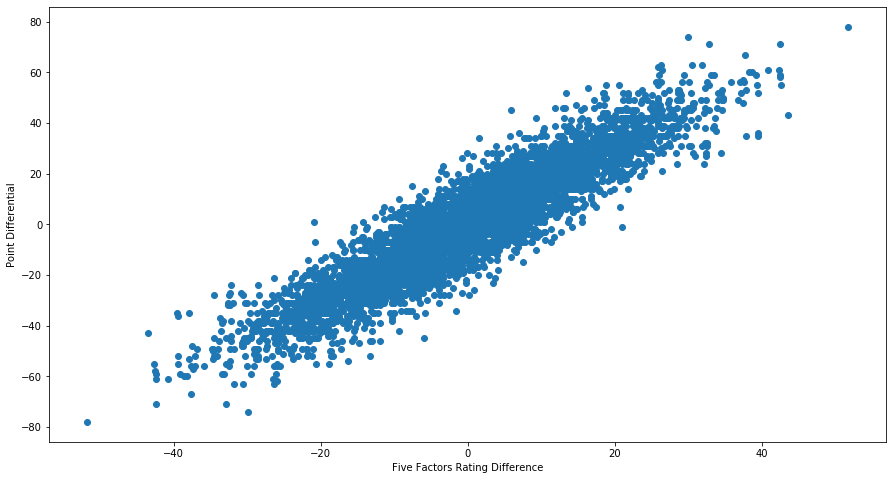

In [183]:
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(15,8))
ax.scatter(stored_game_boxes['5FRDiff'], stored_game_boxes.PtsDiff);
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential");

In [184]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,0.416667,0.604651,6.20,1.69,0.045977,0.22,50.543808,-5.360082,0.402184,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,0.769231,0.573333,4.80,1.47,0.083333,-0.22,55.903890,5.360082,0.402184,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,0.400000,0.333333,0.75,0.44,0.169811,0.22,30.857521,0.772567,0.057968,0.180635
1,Wake Forest,2016,400869421,7.0,4.0,0.350175,0.339623,0.018868,3.094340,28.363636,...,0.181818,0.555556,3.50,0.22,0.119403,-0.22,30.084955,-0.772567,0.057968,0.180635
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,0.071429,0.400000,7.00,0.98,0.057971,-0.22,35.599845,-32.552942,2.442553,2.528887


In [185]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3.2)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.2)]
msk = np.random.rand(len(basis)) < 0.80
train_data = basis[msk]
test_data = basis[~msk]

In [186]:
outliers

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Bowling Green,2016,400869287,3.0,-74.0,0.000002,0.297297,0.054054,3.878378,22.647059,...,0.235294,0.451613,0.750000,1.32,0.121622,0.88,28.213901,-29.934430,2.246078,3.341743
1,Memphis,2016,400869287,77.0,74.0,0.999998,0.472973,0.202703,8.189189,33.588235,...,0.588235,0.625000,7.000000,0.44,0.148649,-0.88,58.148331,29.934430,2.246078,3.341743
0,Michigan,2016,400869636,78.0,78.0,0.996516,0.555556,0.152778,8.347222,41.166667,...,0.611111,0.709091,7.000000,1.20,0.277778,0.00,64.805357,51.780738,3.885278,3.522378
1,Rutgers,2016,400869636,0.0,-78.0,0.003484,0.111111,0.000000,0.703704,24.588235,...,0.058824,0.000000,0.000000,1.20,0.097222,0.00,13.024619,-51.780738,3.885278,3.522378
0,Kansas,2017,400934532,0.0,-43.0,0.000013,0.061224,0.000000,0.428571,21.692308,...,0.000000,0.000000,0.000000,2.67,0.102941,0.22,9.948449,-43.562454,3.268633,1.941824
1,TCU,2017,400934532,43.0,43.0,0.999987,0.485294,0.191176,6.941176,38.416667,...,0.583333,0.522727,5.428571,2.45,0.285714,-0.22,53.510903,43.562454,3.268633,1.941824
0,East Carolina,2018,401088766,3.0,-55.0,0.000006,0.080000,0.040000,1.860000,25.666667,...,0.133333,0.222222,1.500000,2.40,0.132530,0.00,16.060714,-42.670093,3.201676,2.483728
1,NC State,2018,401088766,58.0,55.0,0.999994,0.530120,0.180723,7.927711,41.142857,...,0.857143,0.569444,4.833333,2.40,0.240000,0.00,58.730807,42.670093,3.201676,2.483728
0,Nevada,2019,401114193,6.0,-71.0,0.000006,0.253731,0.029851,2.686567,25.562500,...,0.125000,0.250000,3.000000,2.79,0.040541,1.32,27.416971,-32.910486,2.469381,3.206267
1,Oregon,2019,401114193,77.0,71.0,0.999994,0.513514,0.216216,8.418919,44.923077,...,0.846154,0.546875,6.363636,1.47,0.313433,-1.32,60.327458,32.910486,2.469381,3.206267


In [187]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,...,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,Hawai'i,2016,400869090,31.0,-20.0,0.008141,0.500000,0.138889,6.652778,23.000000,...,0.416667,0.604651,6.200000,1.69,0.045977,0.22,50.543808,-5.360082,0.402184,0.903174
1,California,2016,400869090,51.0,20.0,0.991859,0.528736,0.149425,7.126437,37.846154,...,0.769231,0.573333,4.800000,1.47,0.083333,-0.22,55.903890,5.360082,0.402184,0.903174
0,Tulane,2016,400869421,3.0,-4.0,0.649825,0.343284,0.089552,4.179104,25.800000,...,0.400000,0.333333,0.750000,0.44,0.169811,0.22,30.857521,0.772567,0.057968,0.180635
0,Charlotte,2016,400869341,14.0,-56.0,0.000059,0.250000,0.066667,3.616667,31.214286,...,0.071429,0.400000,7.000000,0.98,0.057971,-0.22,35.599845,-32.552942,2.442553,2.528887
1,Louisville,2016,400869341,70.0,56.0,0.999941,0.681159,0.289855,9.275362,33.866667,...,0.733333,0.779661,6.363636,1.20,0.100000,0.22,68.152787,32.552942,2.442553,2.528887


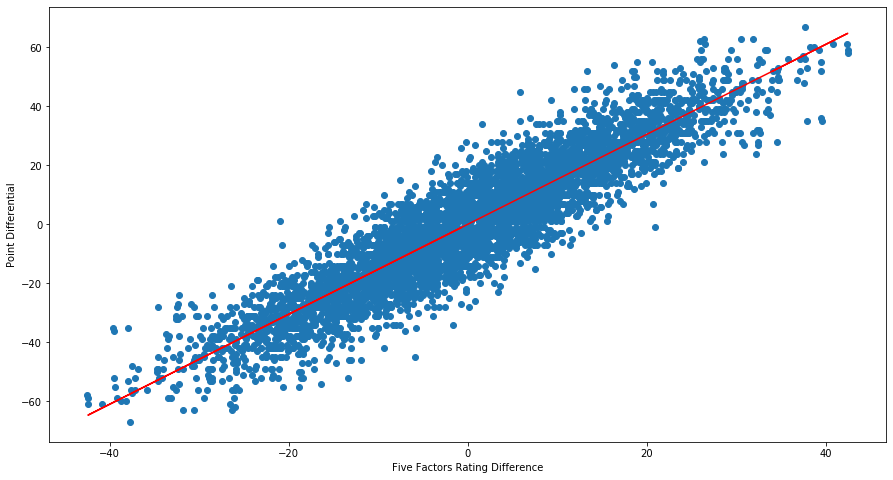

In [188]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

f, ax = plt.subplots(figsize=(15,8))
ax.scatter(basis['5FRDiff'], basis.PtsDiff)
ax.set_xlabel("Five Factors Rating Difference")
ax.set_ylabel("Point Differential")

xfit = test_data['5FRDiff']
yfit = model.predict(xfit[:, np.newaxis])
ax.plot(xfit, yfit, color='red', label='Linear Regression');

In [189]:
print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

test = pd.DataFrame({
    'ActPtsDiff':test_data['PtsDiff'],
    'PredPtsDiff' : yfit
})

test.corr()

Linear Regression: y = 1.52488x + 0.01386


,ActPtsDiff,PredPtsDiff
ActPtsDiff,1.00000,0.90762
PredPtsDiff,0.90762,1.00000


In [190]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = yfit.mean()
    std = yfit.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {stringify_entry(max_box_row.PtsDiff)}")
    print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    print("")
    proj_point_diff = model.coef_[0] * stringify_entry(max_box_row['5FRDiff']) + model.intercept_
    print(f"Proj MOV by 5FRDiff: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * stats.norm.cdf(z)):.2f}%")

In [191]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
5FRDiff for Virginia Tech: -2.8441348535028084

Proj MOV by 5FRDiff: Virginia Tech by -4.0 (exact value: -4.323096058945071)
Z score: -0.2344713692075058
Win Prob for Virginia Tech: 40.73%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,26.0,2.214286,0.833333,0.428571,0.567568,5.166667,1.15,0.118421,-0.66,43.767287,2.844135
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,31.4,2.266667,0.625000,0.533333,0.448980,3.375000,1.81,0.158730,0.66,40.923152,-2.844135


In [192]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
5FRDiff for Georgia Tech: -6.446915002560175

Proj MOV by 5FRDiff: Georgia Tech by -10.0 (exact value: -9.816894339085813)
Z score: -0.5117979598755849
Win Prob for Georgia Tech: 30.44%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,17.444444,3.111111,0.500000,0.444444,0.47619,3.500000,0.93,0.177419,-0.66,35.143715,-6.446915
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,38.750000,1.750000,0.333333,0.750000,0.40000,2.333333,1.59,0.158730,0.66,41.590630,6.446915


In [193]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
5FRDiff for Georgia Tech: 2.2719611935683304

Proj MOV by 5FRDiff: Georgia Tech by 3.0 (exact value: 3.478323539691319)
Z score: 0.15934380006833743
Win Prob for Georgia Tech: 56.33%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,23.700000,2.600000,0.833333,0.600000,0.552239,4.5,0.98,0.087719,0.0,44.793036,-2.271961
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,29.636364,2.545455,0.571429,0.636364,0.571429,4.0,0.98,0.075000,0.0,47.064997,2.271961


In [194]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
5FRDiff for Mississippi State: 2.3027801605873464

Proj MOV by 5FRDiff: Mississippi State by 4.0 (exact value: 3.525318688159949)
Z score: 0.1617161121988825
Win Prob for Mississippi State: 56.42%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.084507,5.563380,25.545455,1.818182,0.60,0.454545,0.473684,4.20,1.20,0.155172,0.22,40.57103,-2.30278
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,31.333333,1.750000,0.75,0.333333,0.533333,5.25,0.98,0.154930,-0.22,42.87381,2.30278


In [195]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
5FRDiff for Texas A&M: -4.459529243546278

Proj MOV by 5FRDiff: Texas A&M by -7.0 (exact value: -6.7863745701503095)
Z score: -0.35881751308539667
Win Prob for Texas A&M: 35.99%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,46.176471,4.235294,0.916667,0.705882,0.520548,5.166667,0.49,0.134615,0.0,53.198121,4.459529
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,45.157895,3.894737,0.923077,0.684211,0.505882,5.000000,0.49,0.133333,0.0,48.738592,-4.459529


In [196]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    return stats.norm.cdf(z)

team_wp_frame = pd.DataFrame()
for team in team_list:
    team_wp_frame = team_wp_frame.append(pd.DataFrame({
        'team':[team],
        'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
    }))
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * 12.0)
team_wp_frame['proj_losses'] = 12 - team_wp_frame['proj_wins']
team_wp_frame.sort_values(by=['avg_win_prob'], ascending=False)

,team,avg_win_prob,proj_wins,proj_losses
0,Ohio State,0.956369,11.0,1.0
0,Alabama,0.934420,11.0,1.0
0,Clemson,0.920133,11.0,1.0
0,LSU,0.916316,11.0,1.0
0,Oklahoma,0.890528,11.0,1.0
0,Wisconsin,0.853188,10.0,2.0
0,Utah,0.839255,10.0,2.0
0,Memphis,0.823249,10.0,2.0
0,Georgia,0.814351,10.0,2.0
0,Minnesota,0.803682,10.0,2.0


In [197]:
# Matchup Predictor?

def predict_matchup(team1, team2, year):
    team1_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team1) & (stored_game_boxes.Season == year)]['5FR'].mean()
    team2_avg_ffr = stored_game_boxes[(stored_game_boxes.Team == team2) & (stored_game_boxes.Season == year)]['5FR'].mean()
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
#     print(f"rating diff is {ffr_diff}")
    pred = model.predict([[ffr_diff]])
    mu = yfit.mean()
    std = yfit.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
#     print(f"{team1} should beat {team2} by {pred[0]} and should win {(100 * win_prob):.2f}% of the time")
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech','Clemson',2019)

[0.09420054594774713, -25.73462168206282]

In [198]:
team_triples = [
    ['Texas','Texas Tech',9.5],
    ['Virginia Tech','Virginia',2.5],
    ['Iowa','Nebraska',5.5],
    ['Missouri','Arkansas',11.5],
    ['Memphis','Cincinnati',11.5],
    ['Washington','Washington State',7.5],
    ['Georgia','Georgia Tech',28.5],
    ['Kentucky','Louisville',2.5],
    ['Clemson', 'South Carolina',27.5],
    ['Ohio State','Michigan',8.5],
    ['Indiana','Purdue',7.5],
    ['Miami','Duke',7.5],
    ['Wisconsin','Minnesota',2.5],
    ['Alabama','Auburn',3.5],
    ['Tennessee','Vanderbilt',22.5],
    ['Oregon','Oregon State',19.5],
    ['Notre Dame','Stanford',16.5],
    ['North Carolina','NC State',7.5],
    ['LSU','Texas A&M',16.5],
    ['Florida','Florida State',17.5],
    ['Utah','Colorado',17.5],
    ['Oklahoma','Oklahoma State',13.5],
    ['Arizona State','Arizona',13.5],
    ['Hawai\'i','Army',3.5]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "team": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,team,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ats_pick
0,Alabama,Auburn,3.5,19.370279,0.831867,True,Alabama
0,Oklahoma,Oklahoma State,13.5,17.137568,0.802021,True,Oklahoma
0,LSU,Texas A&M,16.5,17.019353,0.800356,True,LSU
0,Ohio State,Michigan,8.5,11.381392,0.711677,True,Ohio State
0,Hawai'i,Army,3.5,7.834223,0.647741,True,Hawai'i
0,Clemson,South Carolina,27.5,20.683322,0.847990,False,South Carolina
0,Georgia,Georgia Tech,28.5,15.647612,0.780431,False,Georgia Tech
0,Notre Dame,Stanford,16.5,10.588220,0.697858,False,Stanford
0,Memphis,Cincinnati,11.5,8.891406,0.667346,False,Cincinnati
0,Utah,Colorado,17.5,7.804609,0.647186,False,Colorado


In [199]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API
Actual Winner: Virginia
MOV: Virginia by 9
5FRDiff for Virginia: 7.354677412486765

Proj MOV by 5FRDiff: Virginia by 11.0 (exact value: 11.228842990411467)
Z score: 0.5505895330878224
Win Prob for Virginia: 70.90%
Could not find basic game data for game_id 401112521 locally, checking CFB Data API
Could not find drive data for game_id 401112521 locally, checking CFB Data API
Could not find play by play data for game_id 401112521 locally, checking CFB Data API


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30,-9,0.577256,0.394231,0.153846,5.788462,31.600000,2.0,0.857143,0.466667,0.588235,4.285714,1.15,0.088608,0.44,43.911699,-7.354677
1,Virginia,2019,401112521,39,9,0.422744,0.367089,0.240506,9.481013,26.692308,3.0,0.857143,0.538462,0.478261,4.857143,0.71,0.115385,-0.44,51.266376,7.354677


In [200]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Actual Winner: North Carolina
MOV: North Carolina by 16.0
5FRDiff for North Carolina: 4.029038639235814

Proj MOV by 5FRDiff: North Carolina by 6.0 (exact value: 6.1576513503565735)
Z score: 0.29459609895597105
Win Prob for North Carolina: 61.58%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,29.153846,2.923077,0.857143,0.538462,0.507692,5.428571,1.86,0.207547,0.0,46.788375,4.029039
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,26.923077,1.692308,0.750000,0.307692,0.631579,5.250000,1.86,0.127660,0.0,42.759337,-4.029039


In [201]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
5FRDiff for Pittsburgh: 11.981033717834961

Proj MOV by 5FRDiff: Pittsburgh by 18.0 (exact value: 18.28346949052975)
Z score: 0.9067066338533724
Win Prob for Pittsburgh: 81.77%


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,FP,PPD,OppEff,OppRate,OppSR,OppPPD,ExpTO,HavocRate,ExpTODiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,35.285714,1.428571,0.666667,0.428571,0.470588,3.333333,1.91,0.183673,0.0,39.385626,11.981034
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,31.769231,0.769231,0.500000,0.307692,0.263158,2.500000,1.91,0.144928,0.0,27.404592,-11.981034
